Spectra and stds are sequential order
Absolute model line width: 5.768377349628877 km / s

Getting ready - [85.965625 86.434375] GHz GHz
Plotting model spectra
Gathering CDMS table parameters
Begin model loops for  CH3OCHO 
Begin model loops for  CH3CHO 
 C2H5OH  has an incomplete partition function
Estimating by linear fit to log-log Qrot/T relation
Begin model loops for  C2H5OH 
Begin model loops for  CH3OCH3 
No transitions for  DCN  in [85.965625 86.434375] GHz. Continue
No transitions for  OCS  in [85.965625 86.434375] GHz. Continue
Begin model loops for  13CH3OH 
No transitions for  H2CO  in [85.965625 86.434375] GHz. Continue
No transitions for  HC3N  in [85.965625 86.434375] GHz. Continue
No transitions for  C(18)O  in [85.965625 86.434375] GHz. Continue
No transitions for  13CS  in [85.965625 86.434375] GHz. Continue
Begin model loops for  SO2 
Begin model loops for  NH2CHO 
No transitions for  HNCO  in [85.965625 86.434375] GHz. Continue
Begin model loops for  SO 
Begin model

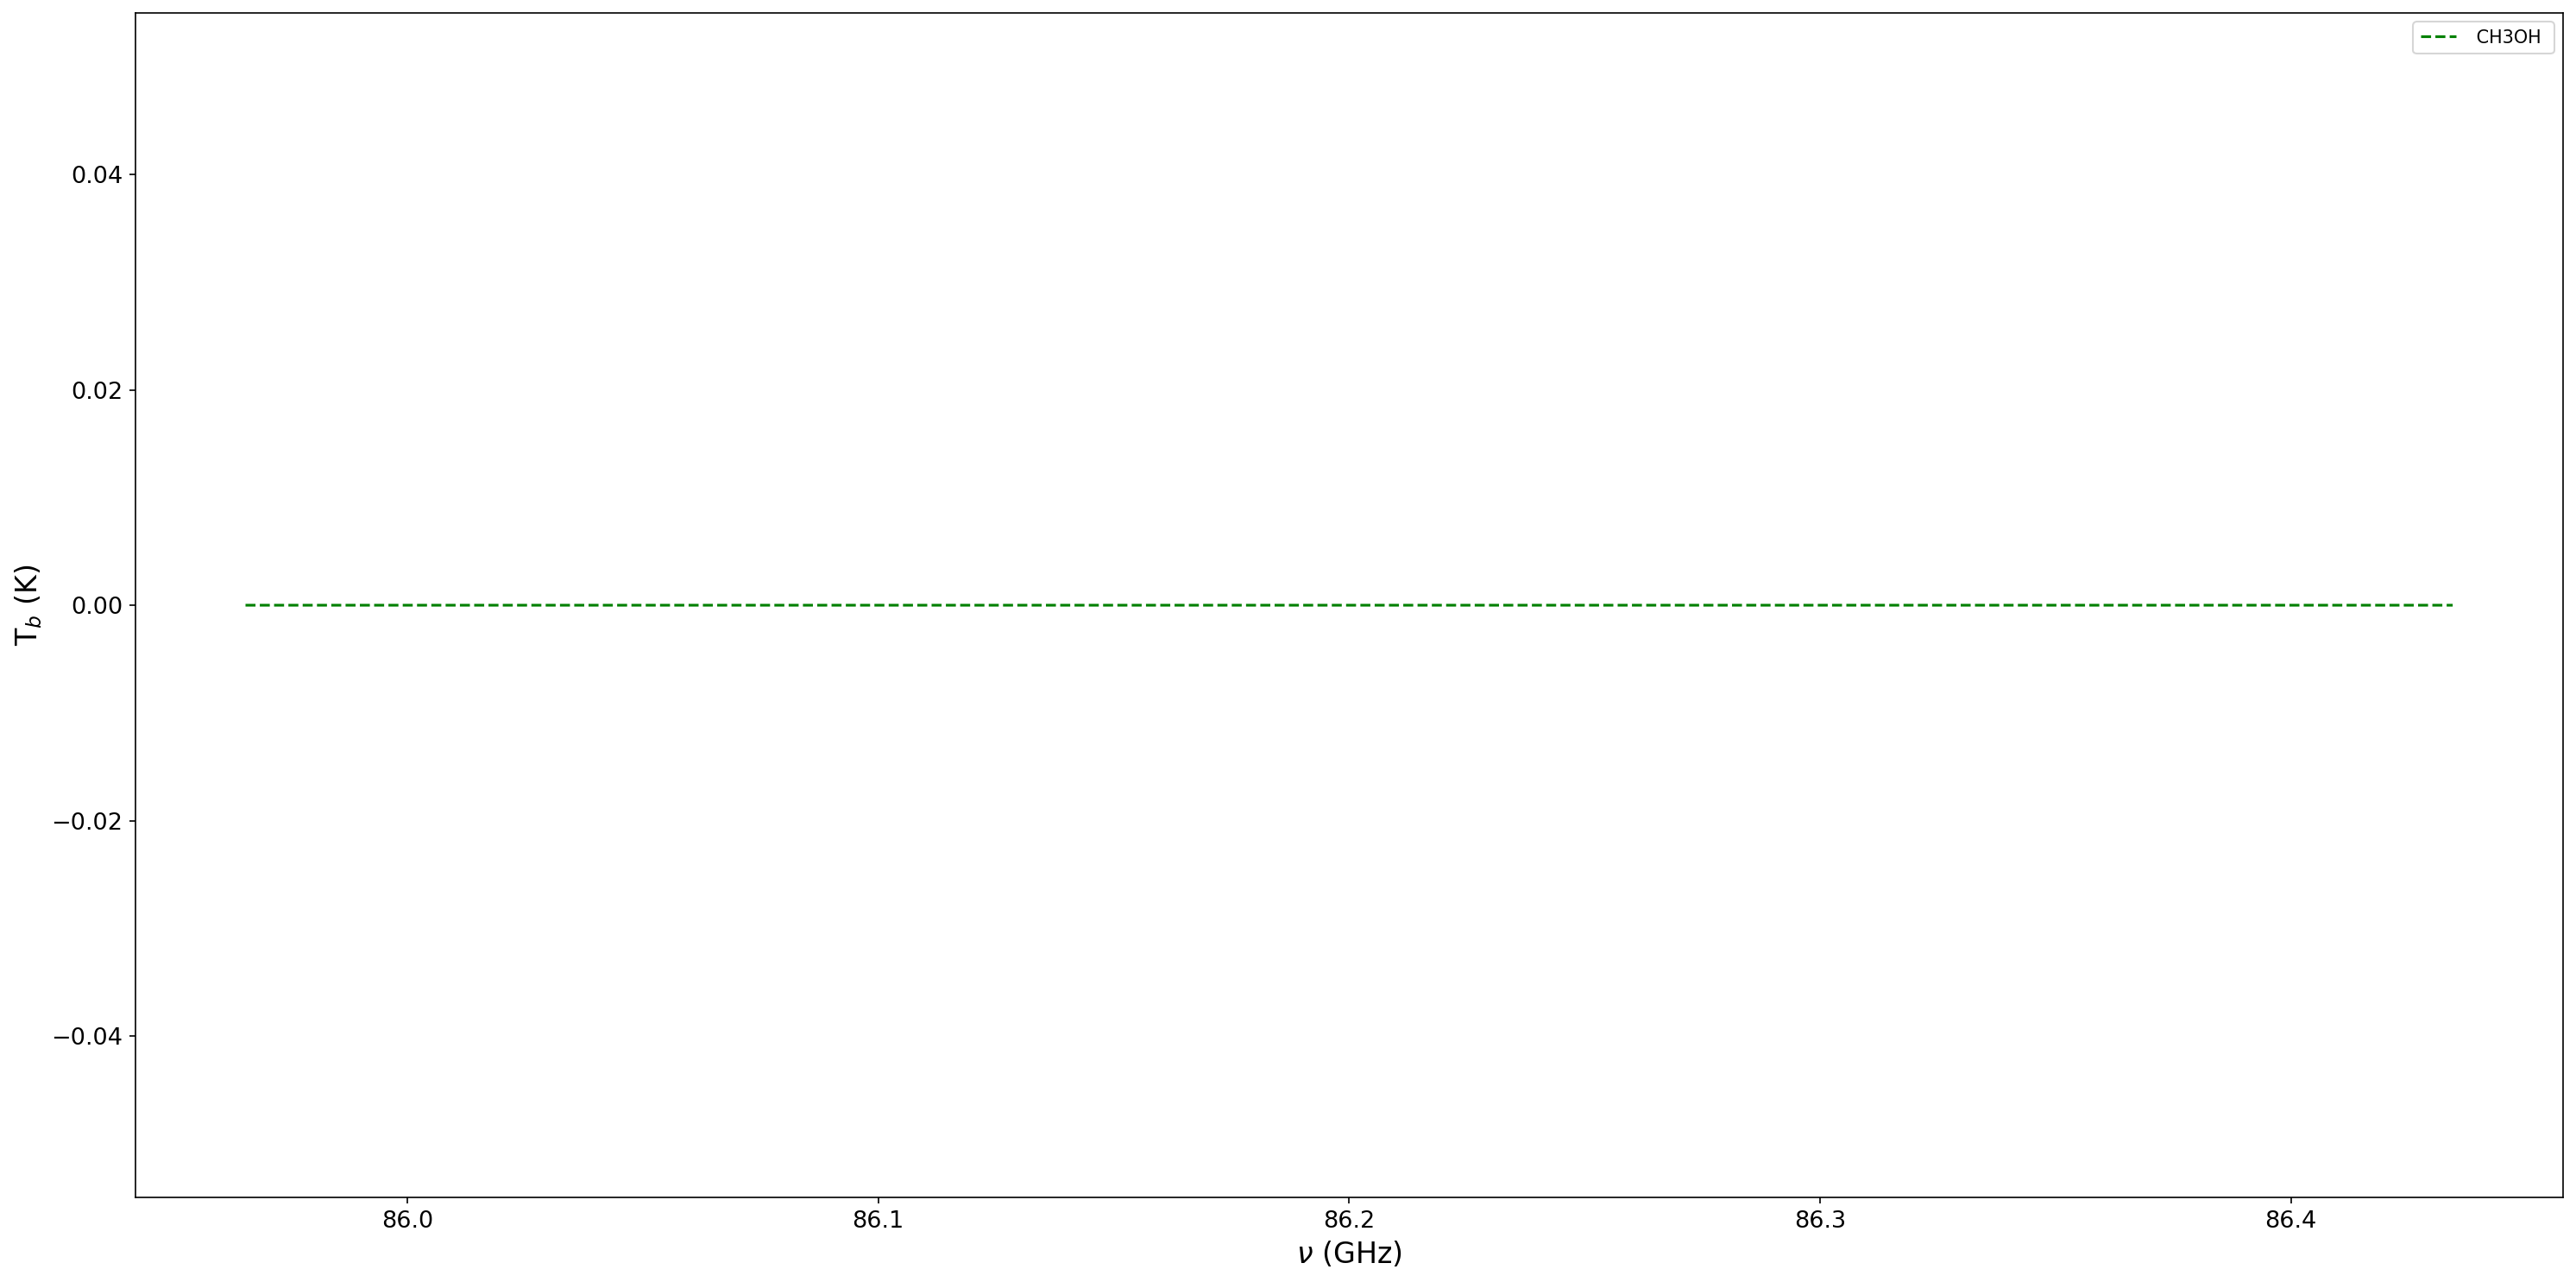

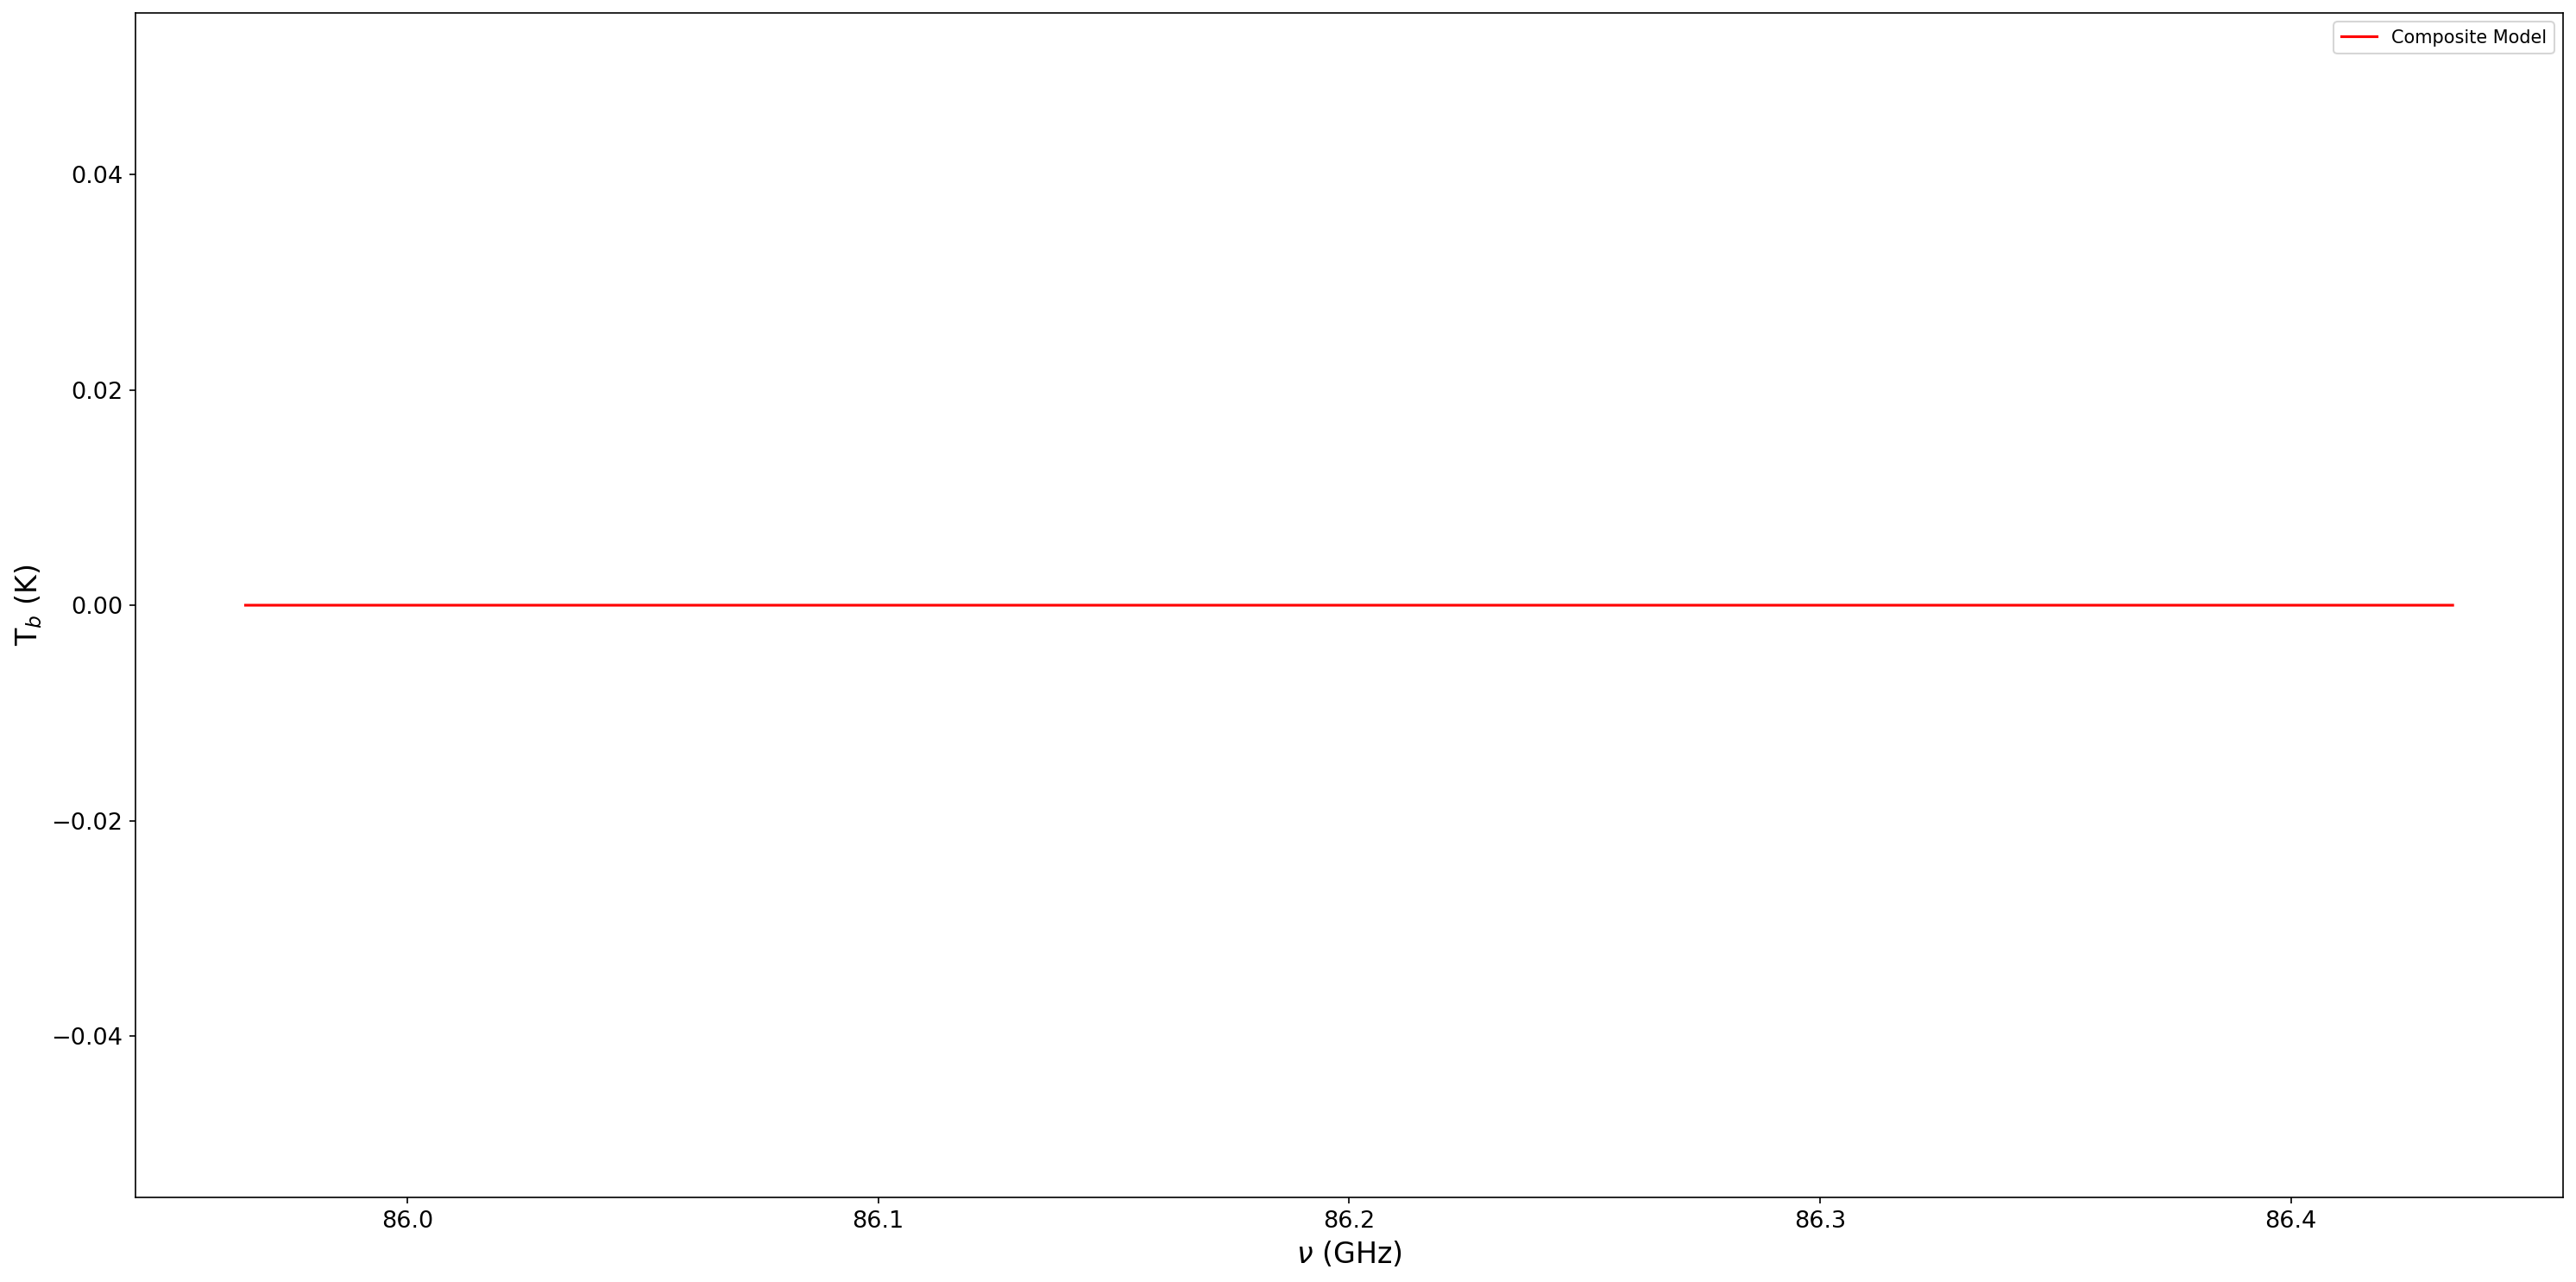

Getting ready - [86.665625 87.134375] GHz GHz
Plotting model spectra
Gathering CDMS table parameters
Begin model loops for  CH3OCHO 
Begin model loops for  CH3CHO 
 C2H5OH  has an incomplete partition function
Estimating by linear fit to log-log Qrot/T relation
Begin model loops for  C2H5OH 
Begin model loops for  CH3OCH3 
No transitions for  DCN  in [86.665625 87.134375] GHz. Continue
No transitions for  OCS  in [86.665625 87.134375] GHz. Continue
No transitions for  13CH3OH  in [86.665625 87.134375] GHz. Continue
No transitions for  H2CO  in [86.665625 87.134375] GHz. Continue
No transitions for  HC3N  in [86.665625 87.134375] GHz. Continue
No transitions for  C(18)O  in [86.665625 87.134375] GHz. Continue
No transitions for  13CS  in [86.665625 87.134375] GHz. Continue
Begin model loops for  SO2 
Begin model loops for  NH2CHO 
No transitions for  HNCO  in [86.665625 87.134375] GHz. Continue
No transitions for  SO  in [86.665625 87.134375] GHz. Continue
Begin model loops for  SiO 
No

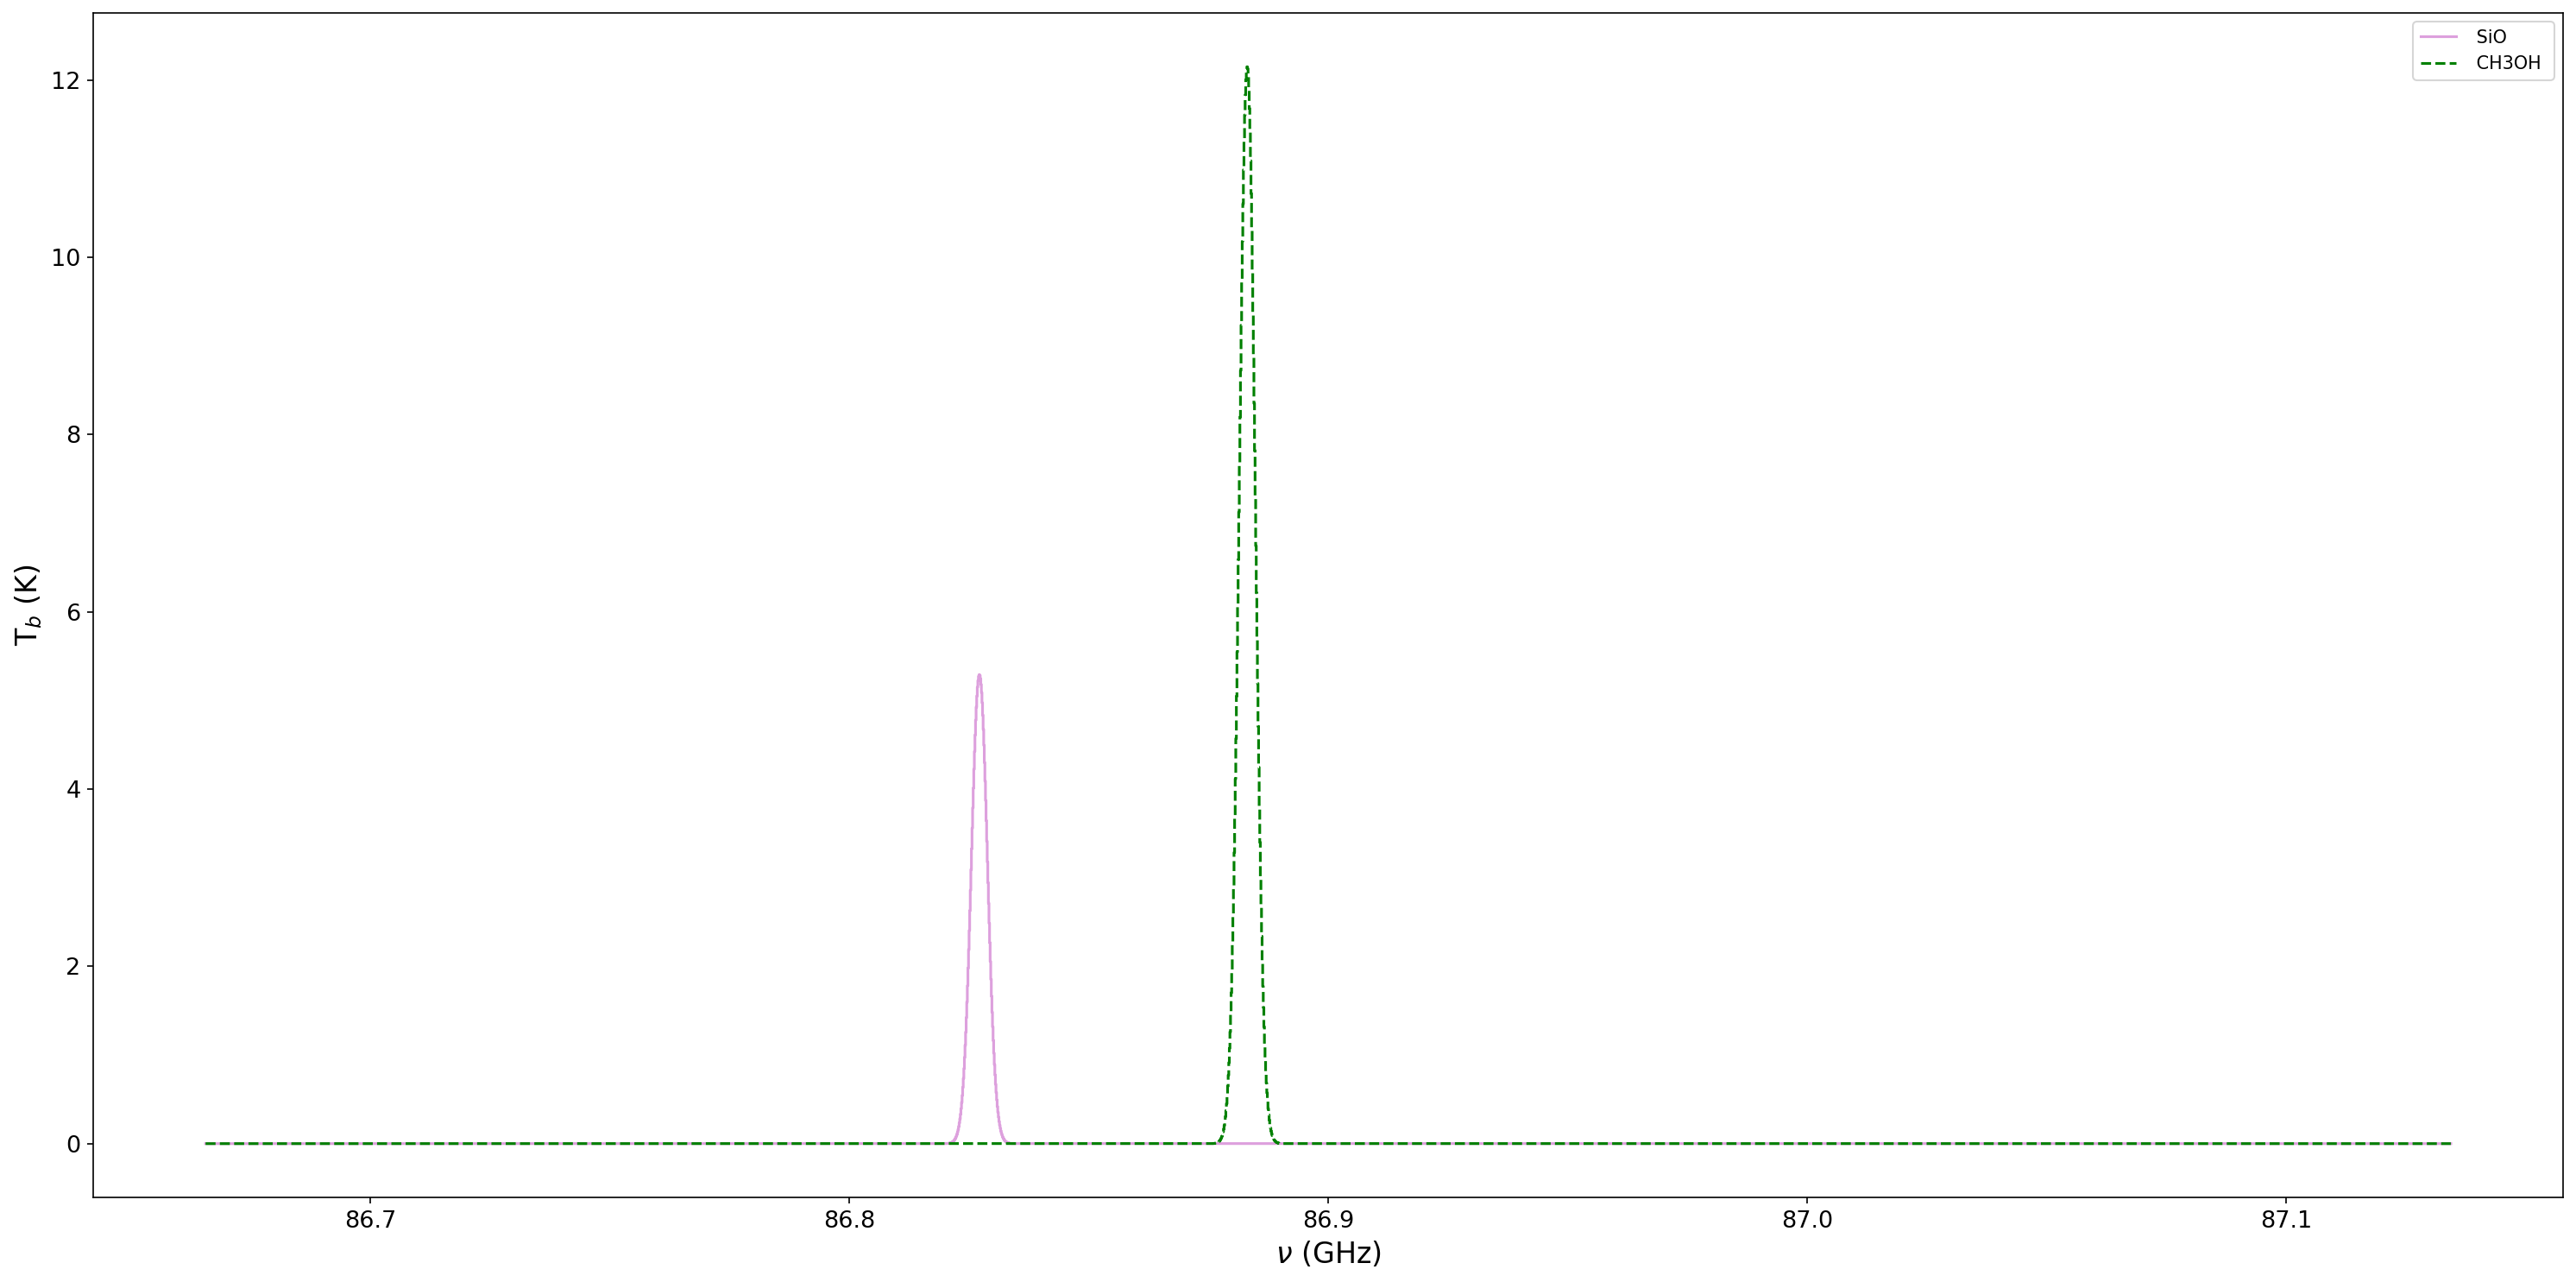

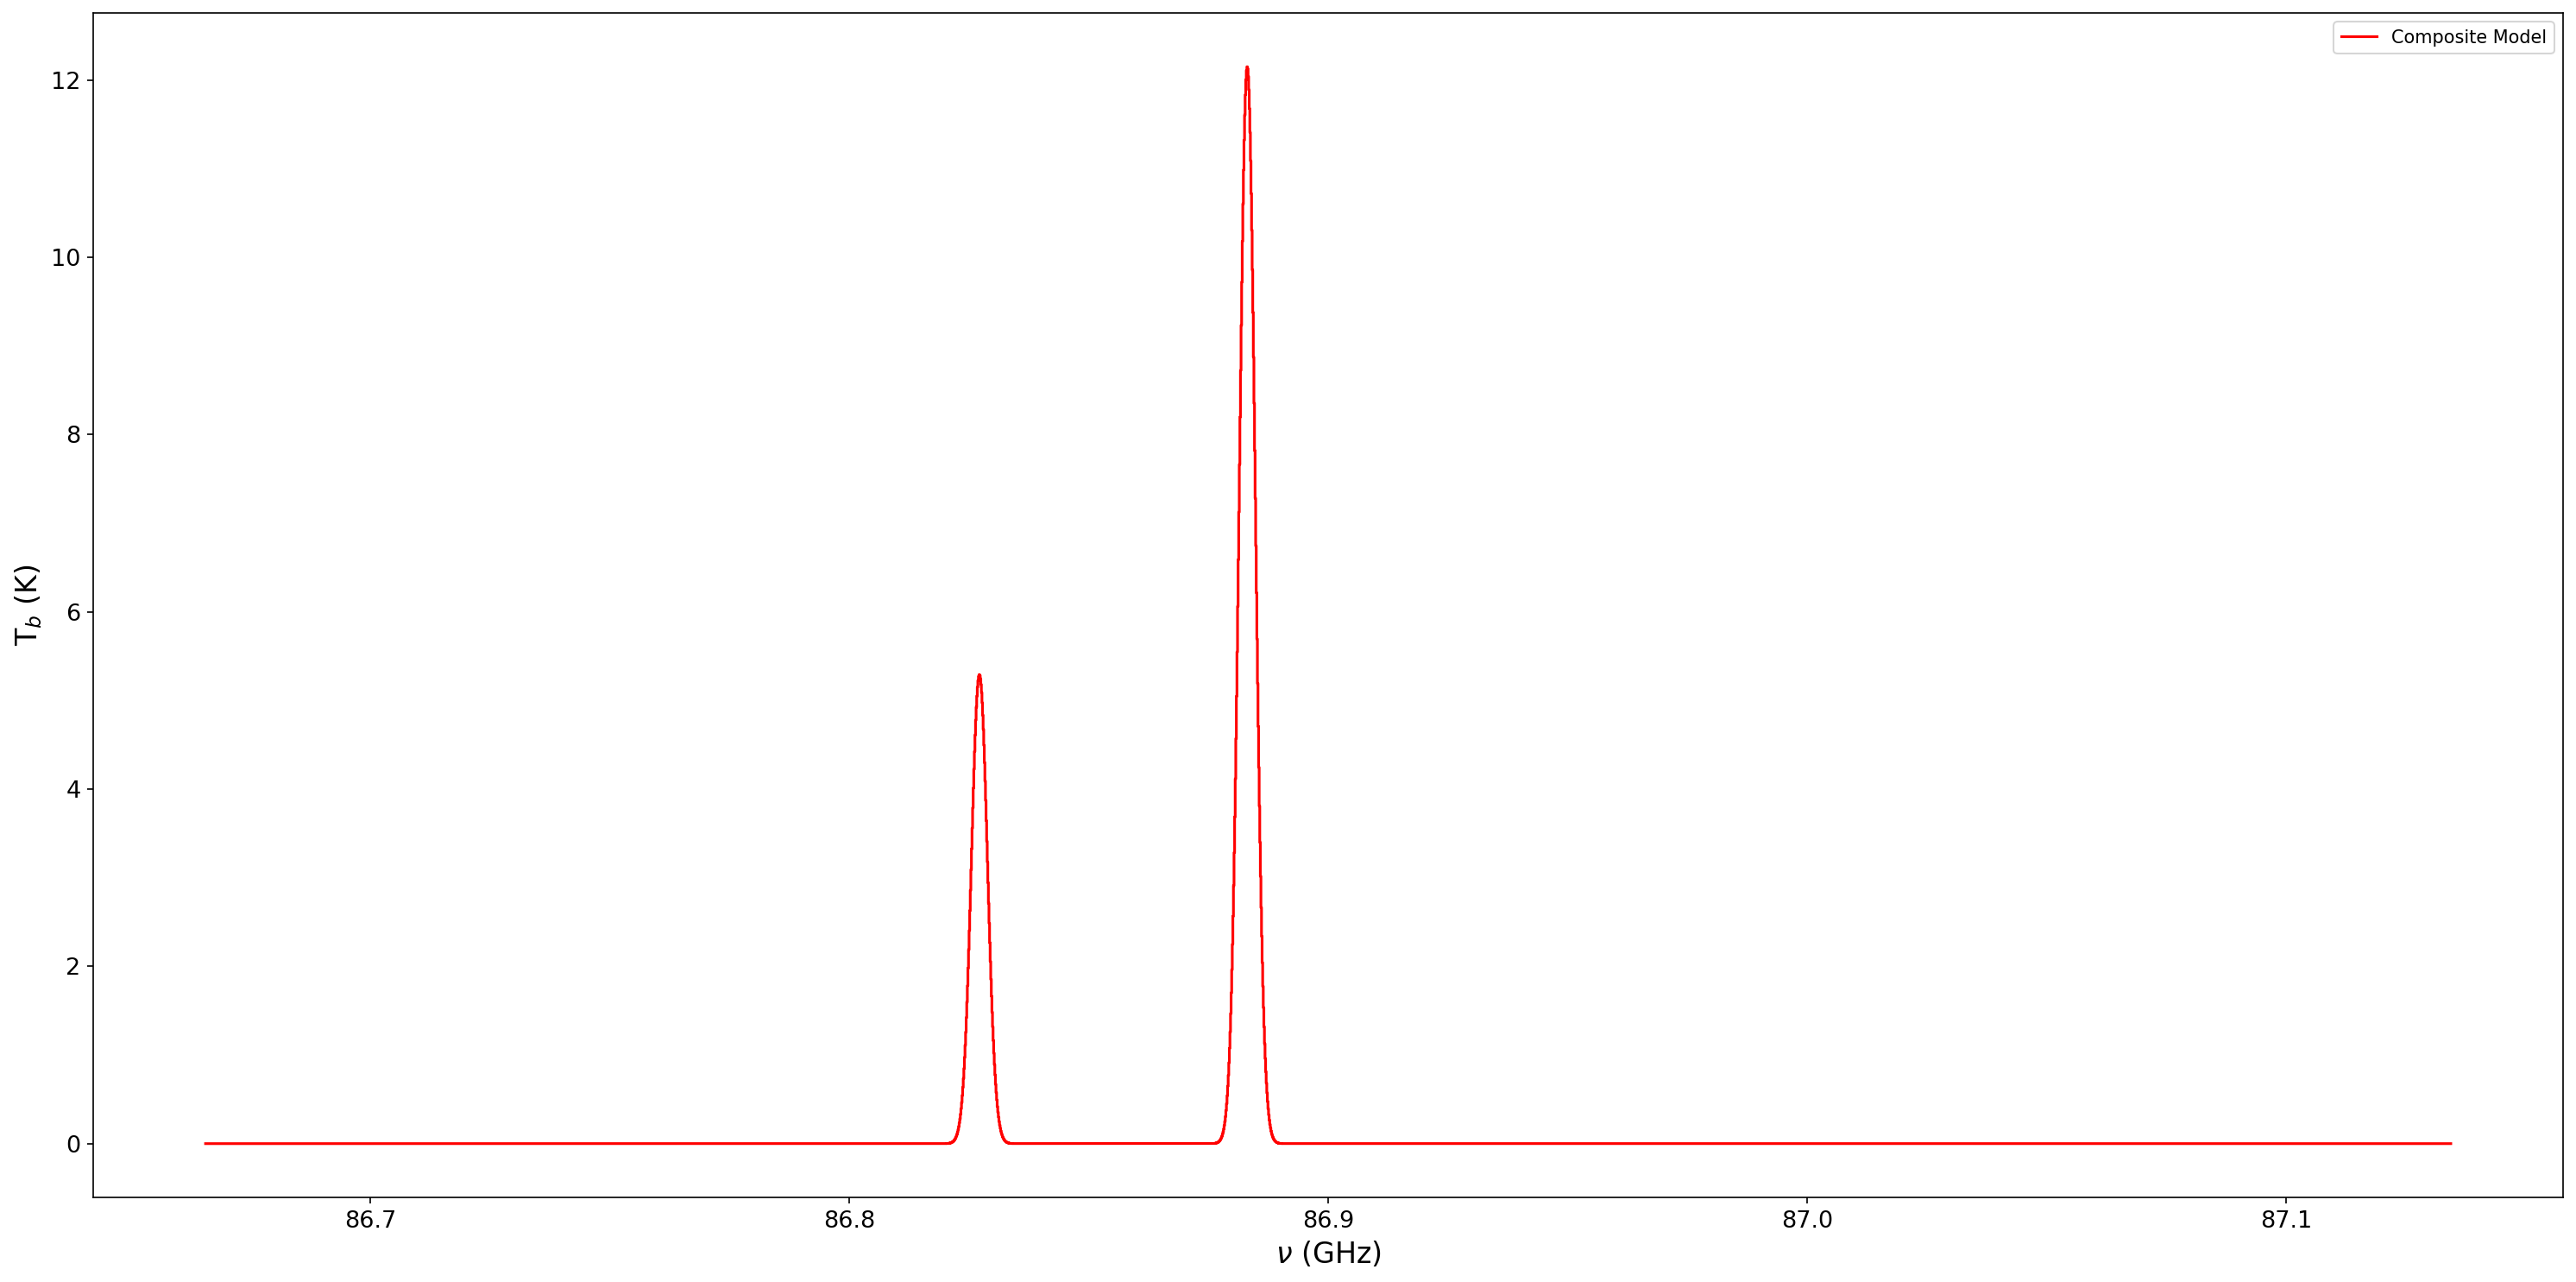

Getting ready - [97.6625 99.5375] GHz GHz
Plotting model spectra
Gathering CDMS table parameters
Begin model loops for  CH3OCHO 
Begin model loops for  CH3CHO 
 C2H5OH  has an incomplete partition function
Estimating by linear fit to log-log Qrot/T relation
Begin model loops for  C2H5OH 
Begin model loops for  CH3OCH3 
No transitions for  DCN  in [97.6625 99.5375] GHz. Continue
No transitions for  OCS  in [97.6625 99.5375] GHz. Continue
Begin model loops for  13CH3OH 
No transitions for  H2CO  in [97.6625 99.5375] GHz. Continue
No transitions for  HC3N  in [97.6625 99.5375] GHz. Continue
No transitions for  C(18)O  in [97.6625 99.5375] GHz. Continue
No transitions for  13CS  in [97.6625 99.5375] GHz. Continue
Begin model loops for  SO2 
Begin model loops for  NH2CHO 
No transitions for  HNCO  in [97.6625 99.5375] GHz. Continue
Begin model loops for  SO 
No transitions for  SiO  in [97.6625 99.5375] GHz. Continue
No transitions for  H2S  in [97.6625 99.5375] GHz. Continue
No transitions

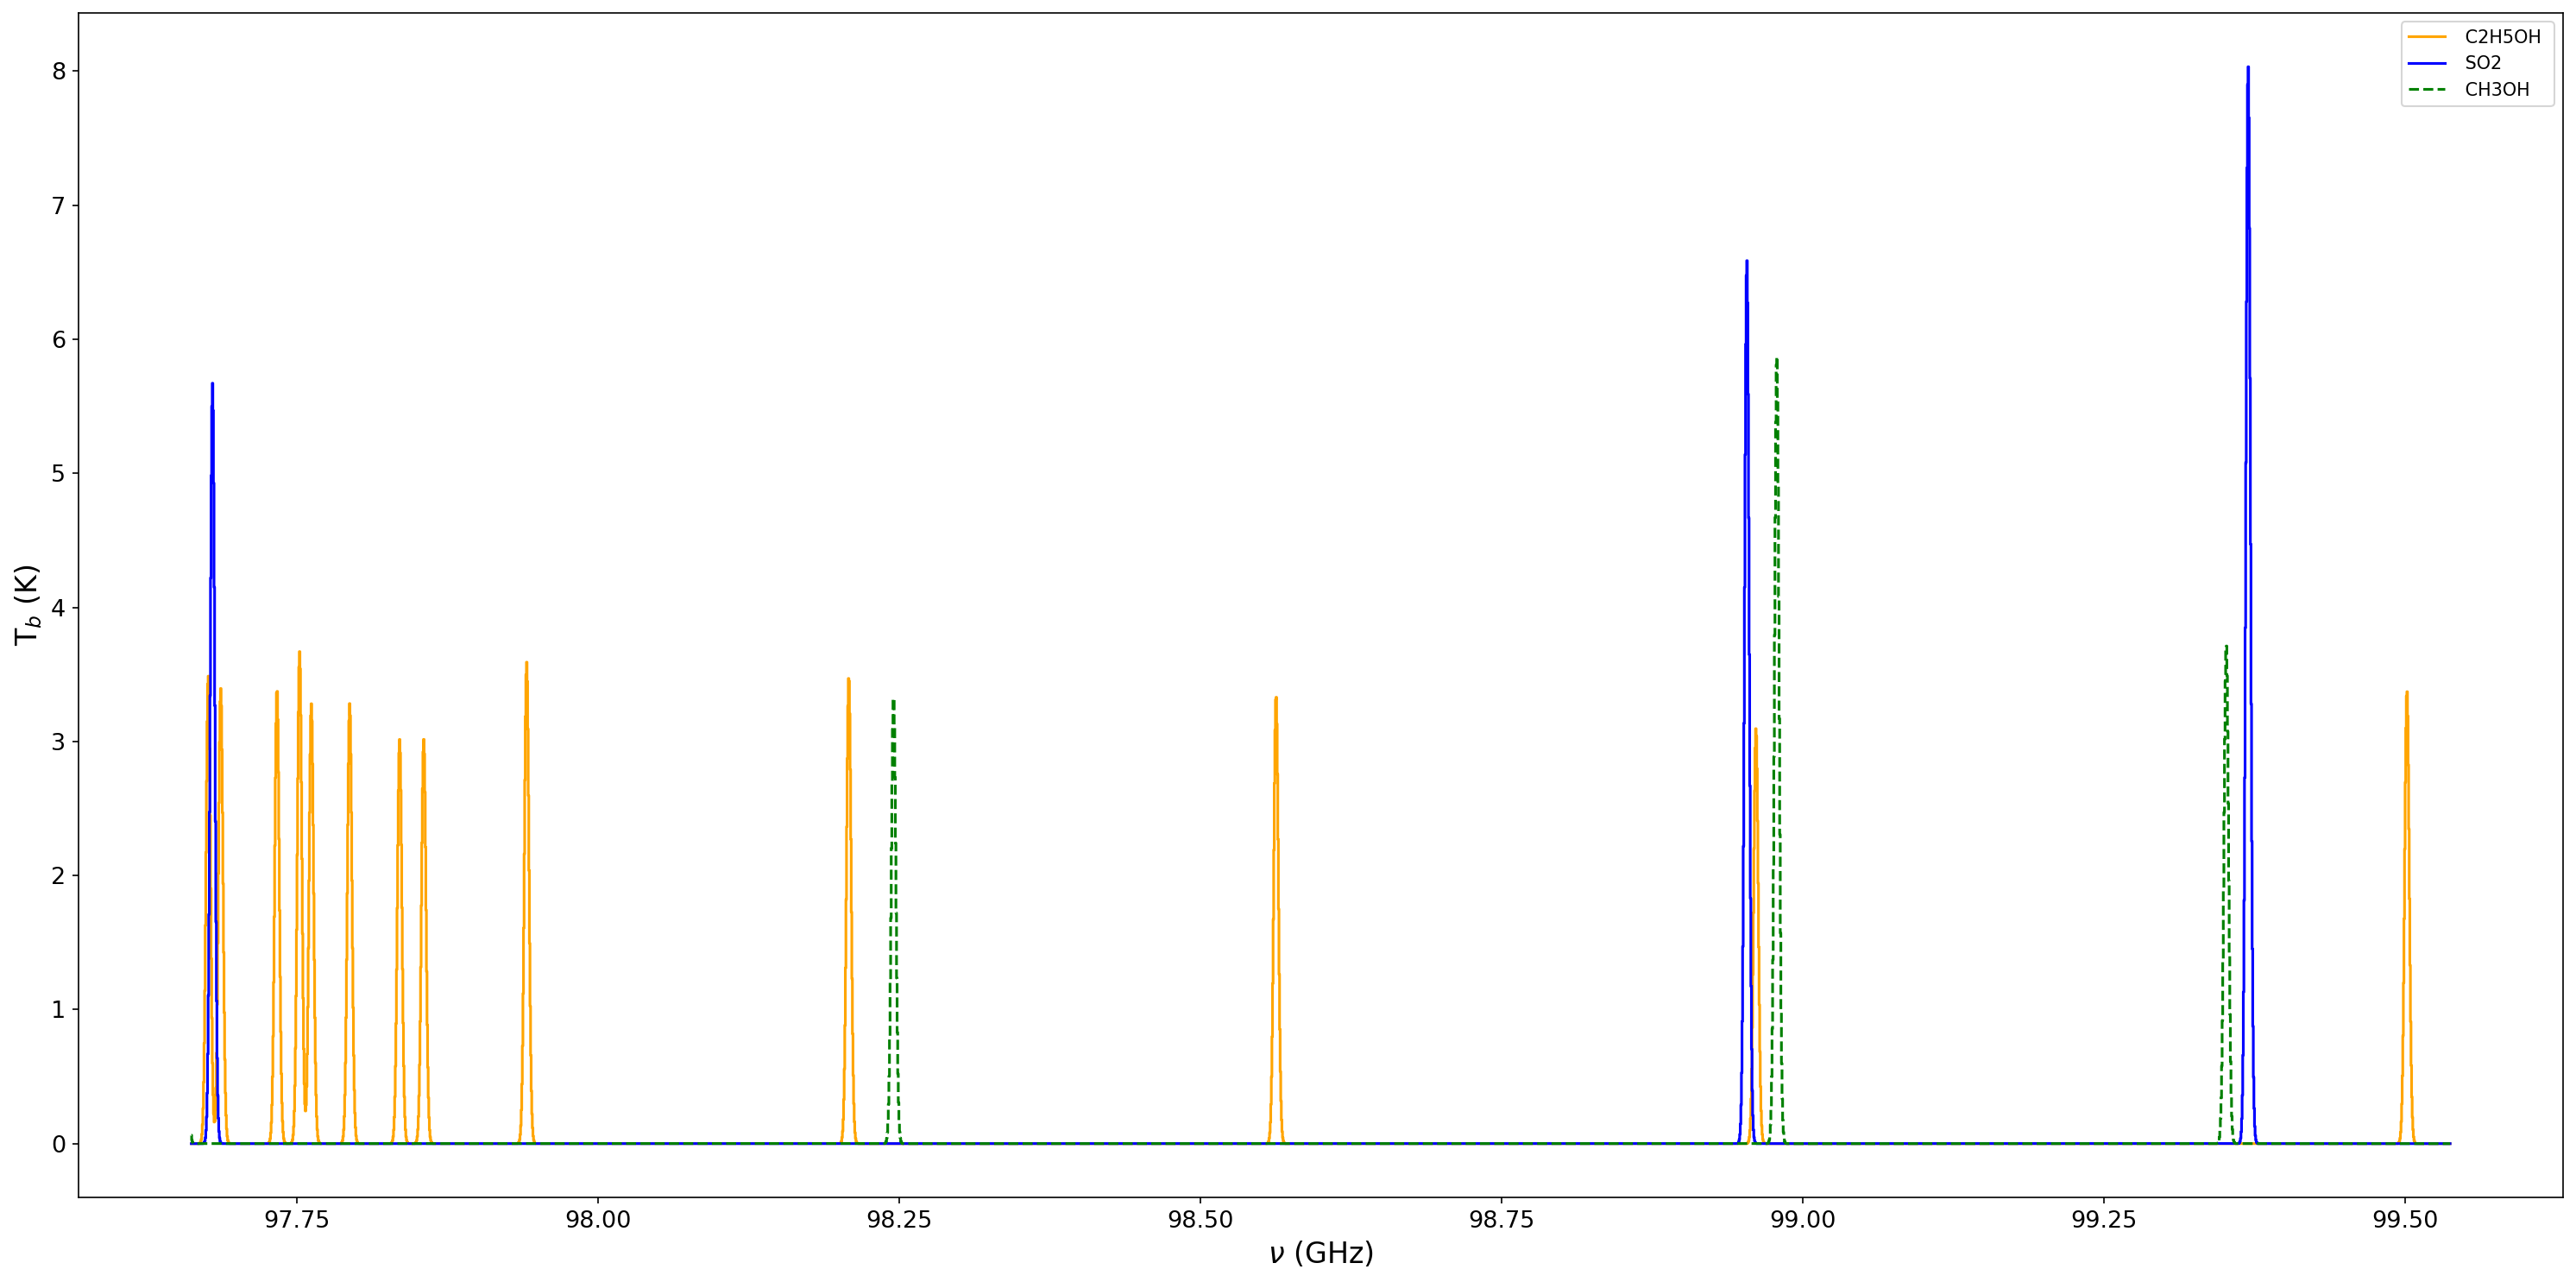

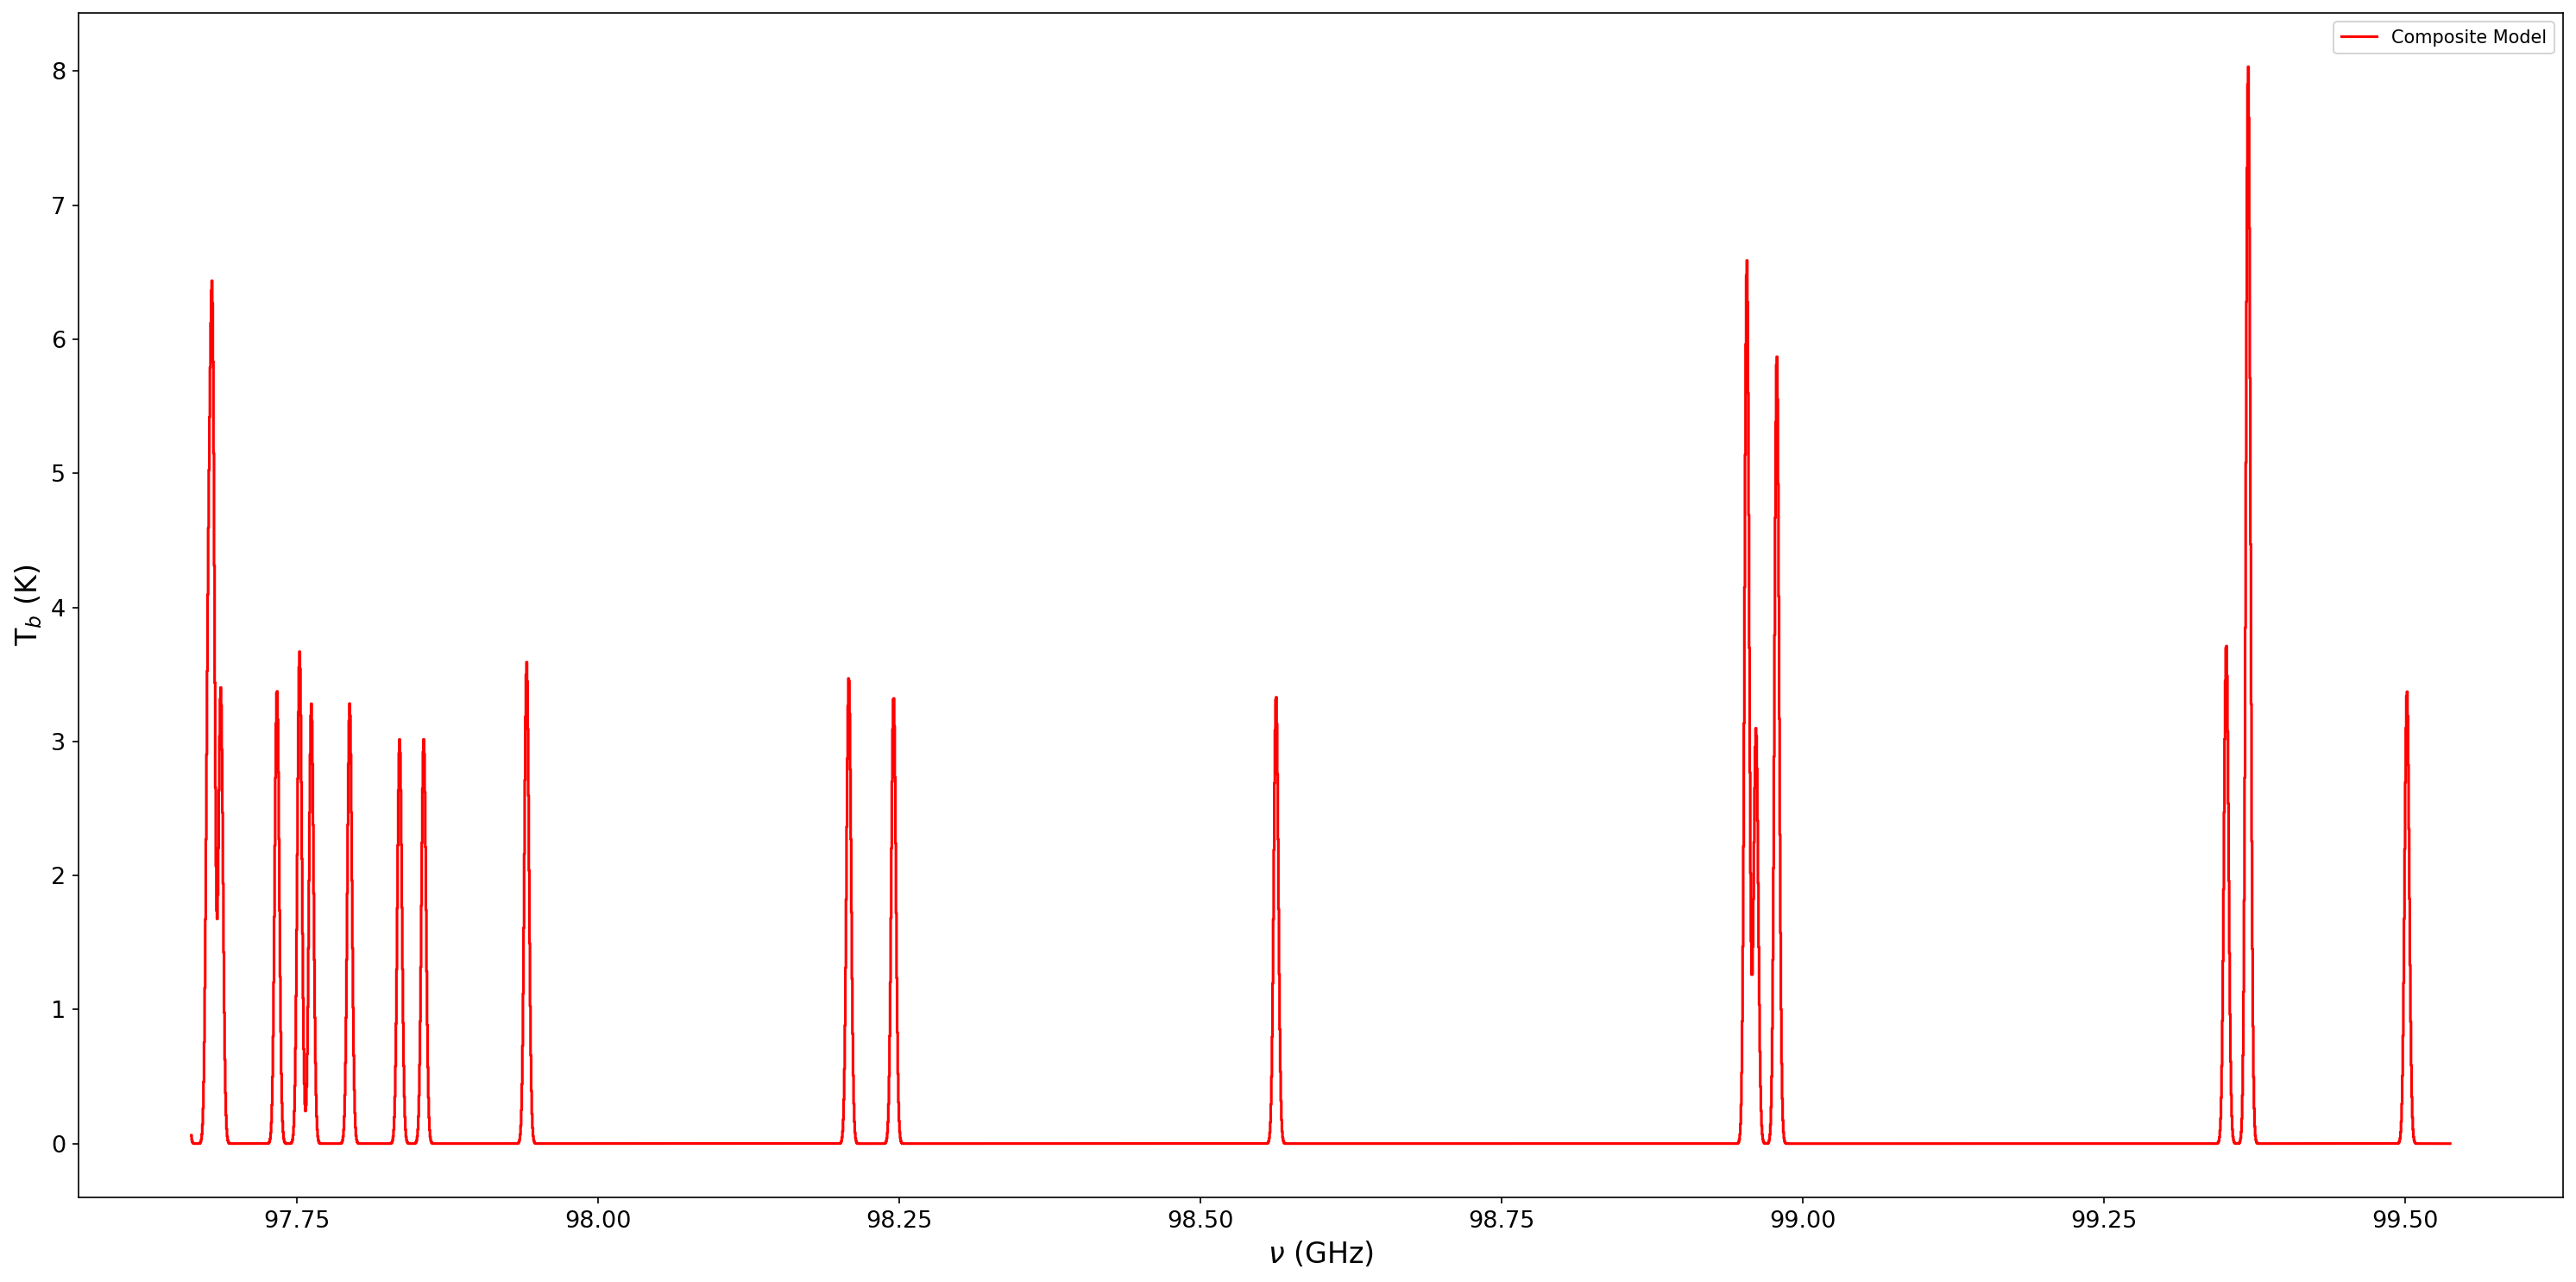

Getting ready - [ 99.5625 101.4375] GHz GHz
Plotting model spectra
Gathering CDMS table parameters
Begin model loops for  CH3OCHO 
Begin model loops for  CH3CHO 
 C2H5OH  has an incomplete partition function
Estimating by linear fit to log-log Qrot/T relation
Begin model loops for  C2H5OH 
Begin model loops for  CH3OCH3 
No transitions for  DCN  in [ 99.5625 101.4375] GHz. Continue
No transitions for  OCS  in [ 99.5625 101.4375] GHz. Continue
Begin model loops for  13CH3OH 
Begin model loops for  H2CO 
Begin model loops for  HC3N 
No transitions for  C(18)O  in [ 99.5625 101.4375] GHz. Continue
No transitions for  13CS  in [ 99.5625 101.4375] GHz. Continue
Begin model loops for  SO2 
Begin model loops for  NH2CHO 
No transitions for  HNCO  in [ 99.5625 101.4375] GHz. Continue
Begin model loops for  SO 
No transitions for  SiO  in [ 99.5625 101.4375] GHz. Continue
No transitions for  H2S  in [ 99.5625 101.4375] GHz. Continue
Begin model loops for  c-HCCCH 
Begin model loops for HC3N v7=

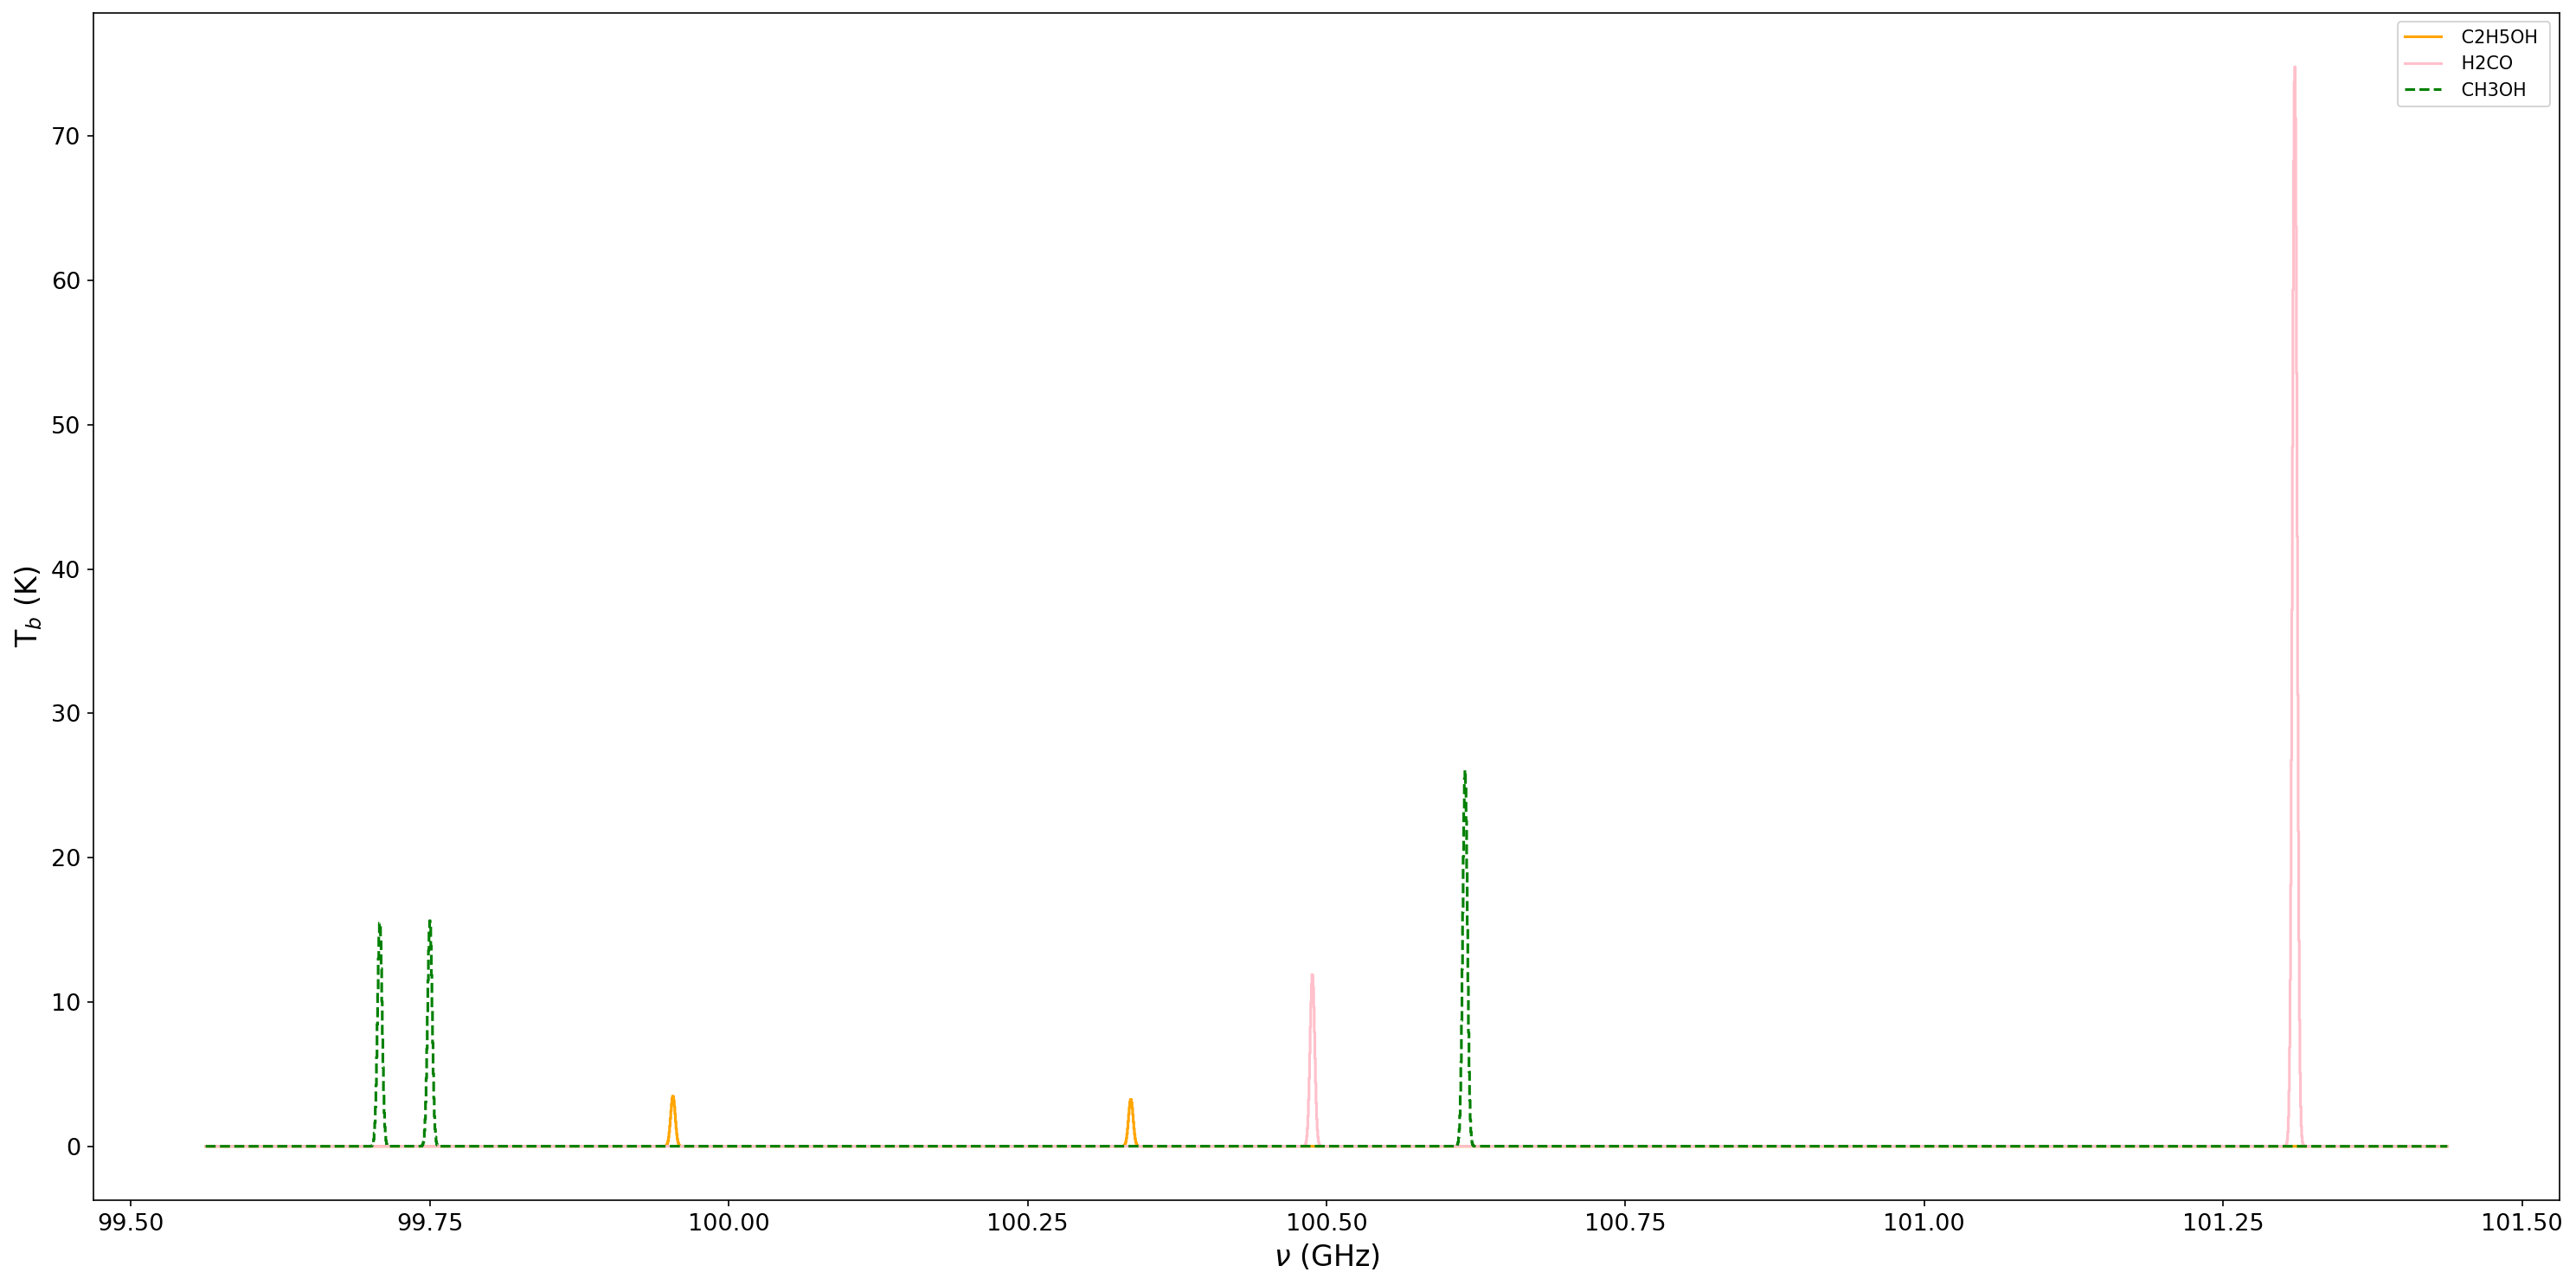

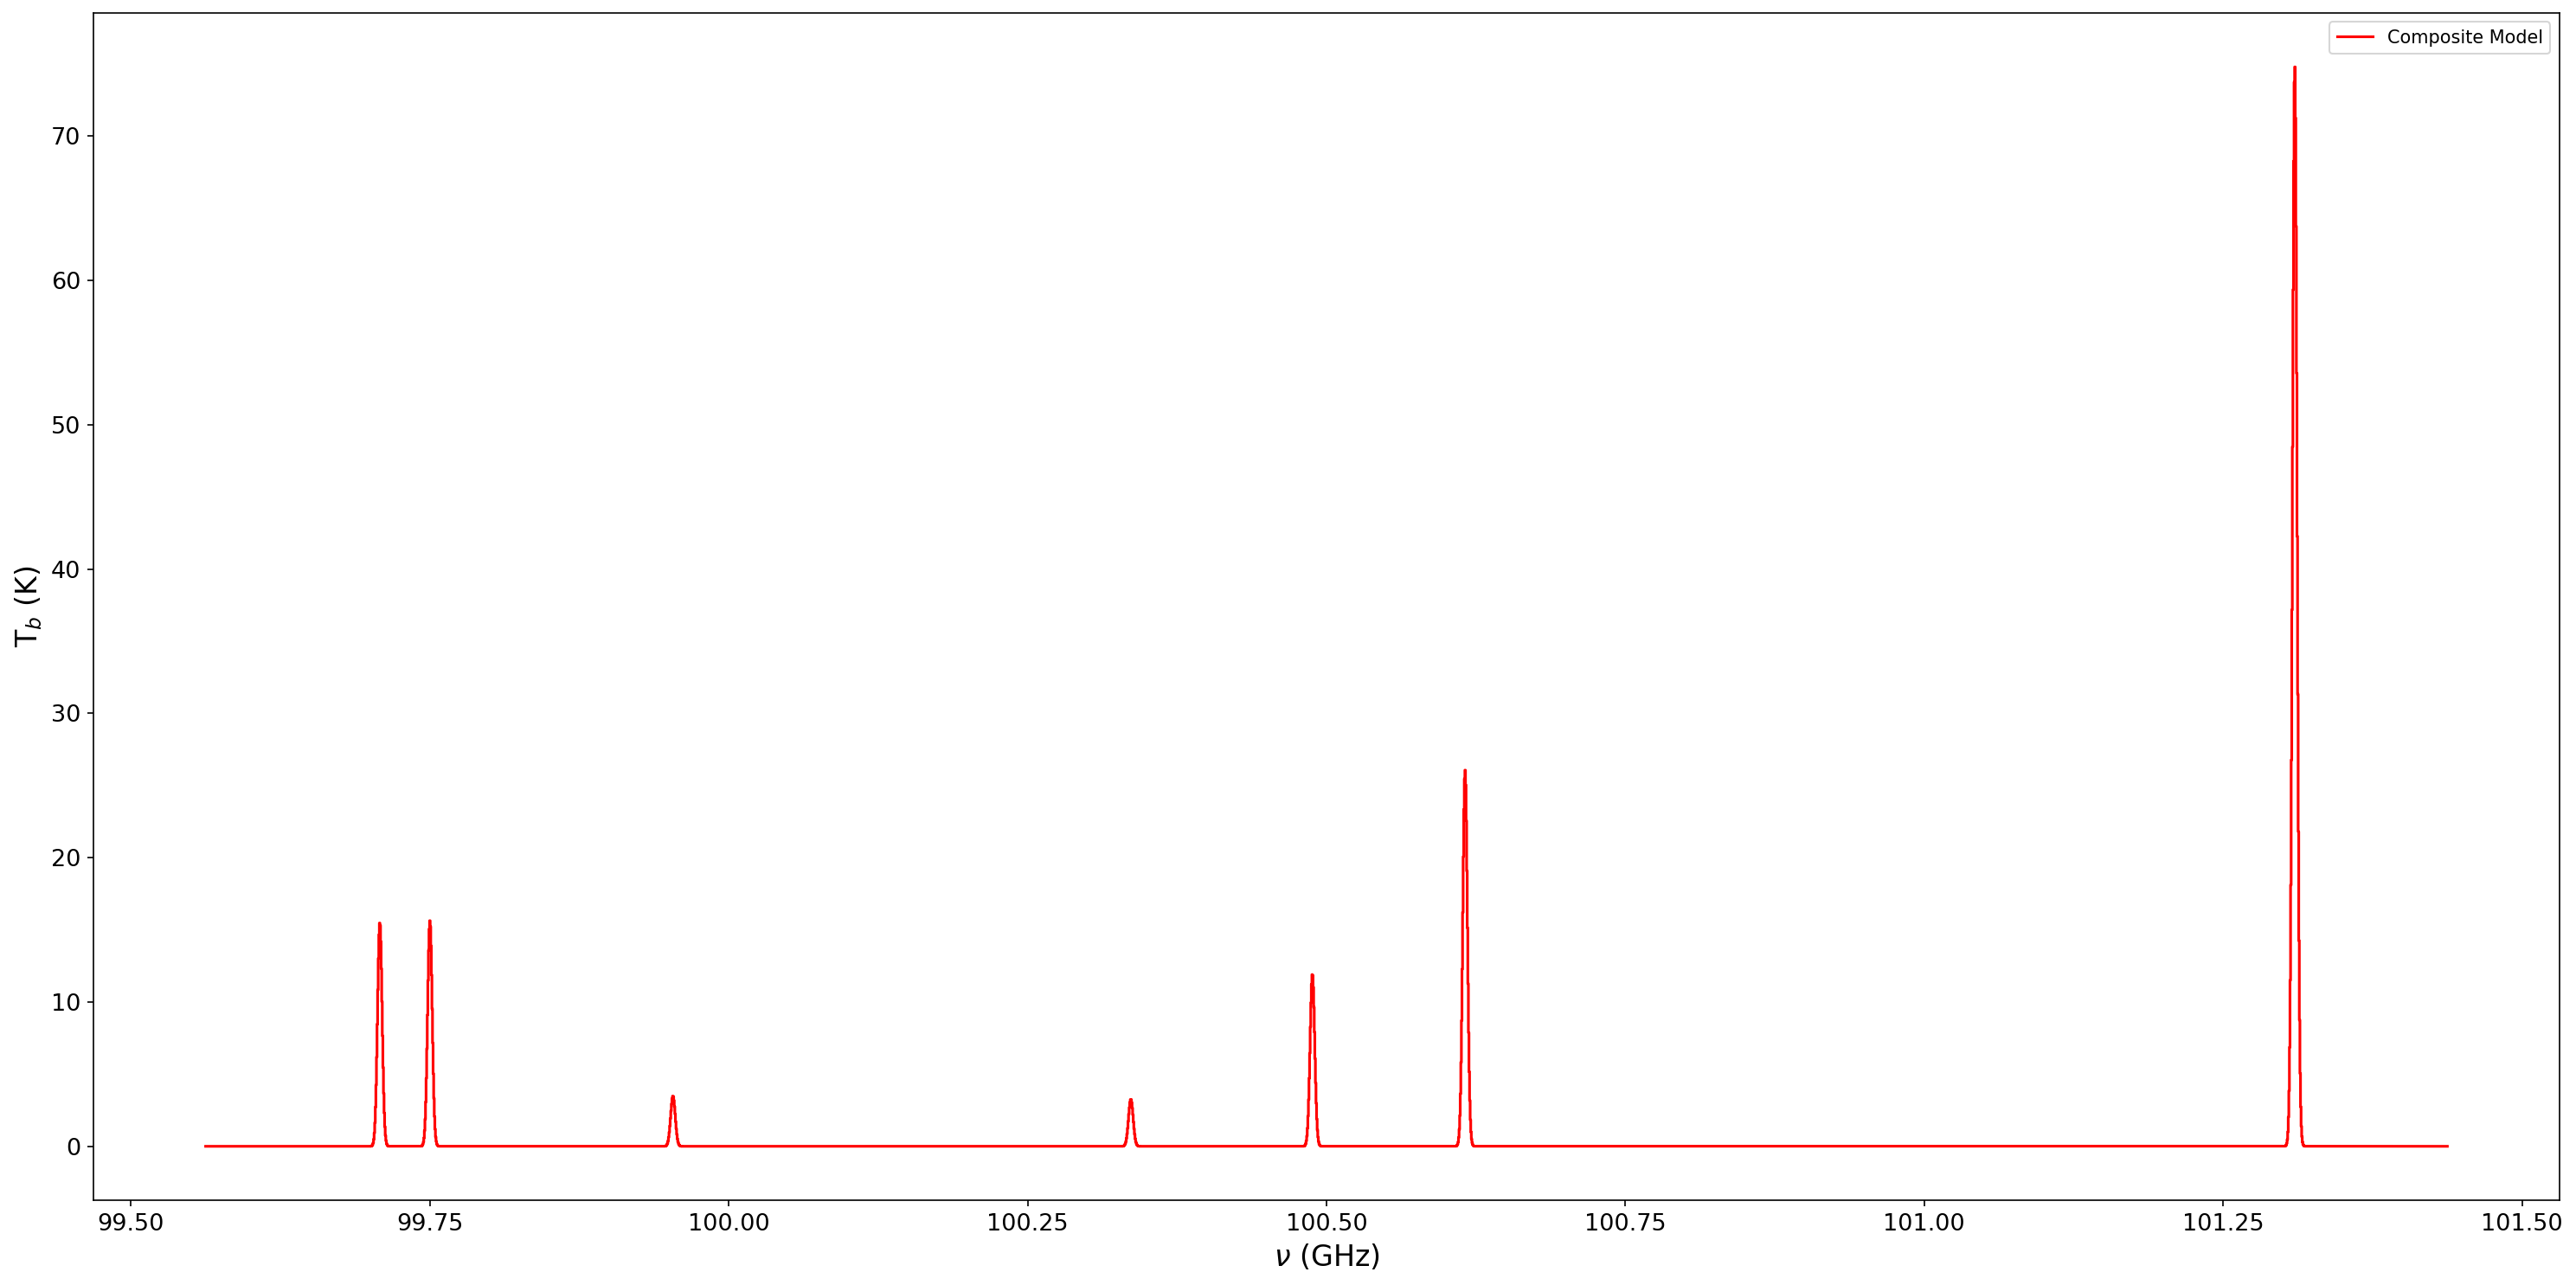

In [60]:
import numpy as np
from pyspeckit.spectrum.models import lte_molecule
from pyspeckit.spectrum.models.lte_molecule import get_molecular_parameters
from astroquery.linelists.cdms import CDMS
import astropy.units as u
import matplotlib.pyplot as plt
from astroquery.splatalogue import utils, Splatalogue
import scipy.constants as cnst
from astropy.io import fits
import glob
from astropy.modeling import models#Fittable1DModel, Parameter, fitting
from utilities import *#Q_rot_asym,mulu,vradio,t_rad,nupper_estimated,opticaldepth,qngrabber
import matplotlib as mpl
import pdb
import sys
from manualspeciesabundances import *
from spectral_cube import SpectralCube as sc
import radio_beam

Splatalogue.QUERY_URL= 'https://splatalogue.online/c_export.php'

mpl.interactive(True)

plt.close('all')

def lineprofile(sigma,nu_0,nu):
    return (1/(np.sqrt(2*np.pi)*sigma))*np.exp(-(nu-nu_0)**2/(2*sigma**2))

def cdms_get_molecule_name(my_molecule_name, **kwargs):
    basename = dict(CDMS.query_lines(min_frequency=1*u.GHz, max_frequency=500*u.GHz, molecule=my_molecule_name, parse_name_locally=True, get_query_payload=True, **kwargs))['Molecules']
    return " ".join(basename.split(" ")[1:])

'''Collect constants for N_tot and N_upper calculations'''

source='SgrB2S'
fnum=fields[source]
dpi={0:150,1:300}
mode=dpi[0]

c=cnst.c*u.m/u.s
k=cnst.k*u.J/u.K
h=cnst.h*u.J*u.s
sigma_sb=cnst.sigma*u.W/((u.m)**(2)*(u.K)**(4))
b_0=24679.98*u.MHz
a_0=127484*u.MHz
c_0=23769.70*u.MHz
m=b_0**2/(a_0*c_0)
Tbg=2.7355*u.K
cdms_catdir=CDMS.get_species_table()
jpl_catdir=JPLSpec.get_species_table()

trotdict={'SgrB2S':300*u.K,'DSi':300*u.K,'DSii':150*u.K,'DSiii':150*u.K,'DSiv':150*u.K,'DSv':100*u.K,'DSVI':300*u.K,'DSVII':200*u.K,'DSVIII':215*u.K,'DSIX':150*u.K,'DS10':150*u.K}

testT=trotdict[source]
#qrot_partfunc=partfunc(testT)#Q_rot_asym(testT).to('')

R_i=1
kappa=((2*b_0)-a_0-c_0)/(a_0-c_0)
f=1


dopplershifts={'SgrB2S':0.000228,'DSi':0.0001865,'DSii':0.000163,'DSiii':0.00017500261911843952,'DSiv':0.00018225233186845314,'DSv':0.0001838576164010067,'DSVI':0.0001661613132158407,'DSVII':0.00016320118280935546,'DSVIII':0.0001662062062062062,'DSIX':0.00015453732389175085,'DS10':0.00015794099431186572}#:0.000190713}/old doppler S: 0.0002306756533745274/0.00015954965399894244/0.00016236367659115043
pixdict={'SgrB2S':(70,59),'DSi':(36,42),'DSii':(22,24),'DSiii':(24,24),'DSiv':(32,31),'DSv':(19,19),'DSVI':(62,62),'DSVII':(75,75),'DSVIII':(50,50),'DSIX':(34,32),'DS10':(35,35)}#SgrB2S:61,64, DSIX:(34,35)
targetpix=pixdict[source]

s_othermol_dshift_v={' CH3CHO ':67.45330305*u.km/u.s,' C2H5OH ':67.45330305*u.km/u.s,' CH3OCHO ':67.45330305*u.km/u.s,' C(18)O ':69.551850256*u.km/u.s,' 13CH3OH ':67.5*u.km/u.s,' SO ':70.5*u.km/u.s}#' CH3OH ':68352.680424
ds2_othermol_dshift_v={' CH3OCHO ':49*u.km/u.s,' CH3CHO ':49*u.km/u.s,' C2H5OH ':49.3*u.km/u.s}#47831.782945392486 m / s
ds5_othermol_dshift_v={}
othermol_dopplershift={' CH3CHO ':0.000225,' C2H5OH ':0.000225,' CH3OCHO ':0.000225,' C(18)O ':0.000232}
ds9_othermol_dshift_v={}

sourceothers={'SgrB2S':s_othermol_dshift_v,'DSi':{},'DSii':ds2_othermol_dshift_v,'DSiii':{},'DSiv':{},'DSv':ds5_othermol_dshift_v,'DSVI':{},'DSVII':{},'DSVIII':{},'DSIX':ds9_othermol_dshift_v,'DS10':{}}
othermol_dshift_v=sourceothers[source]

z=dopplershifts[source]
z_vel=z*c

assemblecubepath=minicube_base+f'{source}/'+minicube_end[fnum]+'*.fits'
print(f'Collecting spectra from {assemblecubepath}')
spectra=glob.glob(assemblecubepath)
spectra.sort()

homedict={'SgrB2S':'/blue/adamginsburg/d.jeff/XCLASS2021/files/SgrB2S/OctReimage_K/','DSi':'/blue/adamginsburg/d.jeff/XCLASS2021/files/DSi/field10originals_K/','DSii':'/blue/adamginsburg/d.jeff/XCLASS2021/files/DSii/field10originals_K/','DSiii':'/aug2023qrotfix/','DSiv':'/aug2023qrotfix/','DSv':f'/aug2023qrotfix/','DSVI':'/aug2023qrotfix/','DSVII':f'/aug2023qrotfix/','DSVIII':f'/aug2023qrotfix/','DSIX':f'/aug2023qrotfix/'}
sourcepath=ch3oh_sourcedict[source]
origsourcepath=f'/blue/adamginsburg/d.jeff/SgrB2DSreorg/field{fnum}/CH3OH/{source}{sourcepath}'

texmappath=origsourcepath+'bootstrap_texmap_3sigma_allspw_withnans_weighted.fits'
    
fwhmpath=glob.glob(origsourcepath+'*fwhm*')[0]
nch3ohpath=glob.glob(origsourcepath+'ntotmap_allspw_withnans_weighted_useintercept_3sigma.fits')[0]
contpath=origsourcepath+'reprojectedcontinuum.fits'

texmapdata=fits.getdata(texmappath)*u.K
fwhmmap=fits.getdata(fwhmpath)*u.km/u.s
nch3ohmap=fits.getdata(nch3ohpath)*u.cm**-2

testT=texmapdata[targetpix[0],targetpix[1]]#350*u.K
fwhm_at_pix=fwhmmap[targetpix[0],targetpix[1]]
nch3oh_at_pix=nch3ohmap[targetpix[0],targetpix[1]]
#print(fwhm_at_pix)

reprojcontfits=fits.open(contpath)
reprojcont=reprojcontfits[0].data*u.Jy
reprojcontrestfreq=225*u.GHz#manual addition 11/9/2022, wiggle room w/i GHz
cntmbeam=radio_beam.Beam.from_fits_header(reprojcontfits[0].header)
reprojcont_K=reprojcont.to('K',cntmbeam.jtok_equiv(reprojcontrestfreq))
continuumlevel=reprojcont_K[targetpix[0],targetpix[1]]

stds=glob.glob(origsourcepath+'errorimgs/std/*.fits')
stds.sort()
images=['spw0','spw1','spw2','spw3']
    
assert 'spw0' in spectra[0] and 'spw0' in stds[0], 'List out of order'

print('Spectra and stds are sequential order')
linewidth=fwhm_at_pix#2.5*u.km/u.s#2.5 km/s is ideal for DSVI
print(f'Absolute model line width: {linewidth}\n')

'''
sgrb2scolumns={' CH3OH ':1.7e18*u.cm**-2,' CH3OCHO ':3e16*u.cm**-2, ' CH3CHO ':1.5e16*u.cm**-2,' C2H5OH ':9e16*u.cm**-2,' CH3OCH3 ':9e15*u.cm**-2,' DCN ':3.5e16*u.cm**-2, ' OCS ':6e17*u.cm**-2,' 13CH3OH ':7e17*u.cm**-2,' H2CO ':7e17*u.cm**-2,' HC3N ':1e16*u.cm**-2, ' C(18)O ':1.3e19*u.cm**-2,' 13CS ':3e16*u.cm**-2,' SO2 ':2e17*u.cm**-2,' NH2CHO ':9e15*u.cm**-2,' HNCO ':3e17*u.cm**-2,' SO ':5e17*u.cm**-2,' SiO ':1e15*u.cm**-2,' H2S ':2e18*u.cm**-2,' c-HCCCH ':5e15*u.cm**-2, 'HC3N v7=1':5e15*u.cm**-2,' H213CO ':7e16*u.cm**-2,' 13CH3CN ':1e16*u.cm**-2,' CH2CHCN ':4e15*u.cm**-2,' 18OCS ':3e17*u.cm**-2,' CH3NCO, vb = 0 ':1e16*u.cm**-2,' CH3CH2CN ':1.5e16*u.cm**-2,}#' 13CH3CCH ':1e17*u.cm**-2}#' NH2CN ':1e15*u.cm**-2,}#' 13CH3OCH3 ':1e14*u.cm**-2}#'CH3OCHO v=1':1e17*u.cm**-2}#' CH3O13CHO ':1e14*u.cm**-2,' H2CCO ':1e16*u.cm**-2,}#' H2CS ':1e18*u.cm**-2,' CH3(18)OH ':2.5e16*u.cm**-2,' NH2CN ':1e14*u.cm**-2, ' NH2D ':1e15*u.cm**-2, ' t-HCOOH ':5e14*u.cm**-2,' SiS ':1e14*u.cm**-2, ' c-HCCCH ':2.5e15*u.cm**-2, 'Acetone':6e13*u.cm**-2,' CH3C(15)N ':3e13*u.cm**-2,' SiN ':2e15*u.cm**-2, ' CH3NH2 ':9e15*u.cm**-2,}#' HOONO ':5e15*u.cm**-2,' CH3COOH ':2e15*u.cm**-2,
#CDMS - ' CH3OH ':1.2e17*u.cm**-2,

dsicolumns={' CH3OH ':1.7e18*u.cm**-2,' CH3OCHO ':2.5e16*u.cm**-2, ' CH3CHO ':1.2e16*u.cm**-2,' C2H5OH ':9e16*u.cm**-2,' CH3OCH3 ':7e15*u.cm**-2,' DCN ':1.5e16*u.cm**-2, ' OCS ':8e17*u.cm**-2,' 13CH3OH ':7e17*u.cm**-2,' H2CO ':7e17*u.cm**-2,' HC3N ':1.7e16*u.cm**-2, ' C(18)O ':7e19*u.cm**-2,' 13CS ':4e16*u.cm**-2,' SO2 ':7e16*u.cm**-2,' NH2CHO ':9e15*u.cm**-2,' HNCO ':2e17*u.cm**-2,' SO ':9e16*u.cm**-2,' SiO ':1e16*u.cm**-2,' H2S ':3.5e18*u.cm**-2,' c-HCCCH ':5e15*u.cm**-2, 'HC3N v7=1':5e15*u.cm**-2,' H213CO ':7e16*u.cm**-2,' 13CH3CN ':1e16*u.cm**-2,' CH2CHCN ':1e15*u.cm**-2,' 18OCS ':1e17*u.cm**-2,' CH3NCO, vb = 0 ':2.5e15*u.cm**-2,' CH3CH2CN ':1e16*u.cm**-2,}#' HOCN ':1e16*u.cm**-2}#' NH2CO2CH3 v=1 ':1e16*u.cm**-2}#' CH3O13CHO, vt = 0, 1 ':5e16*u.cm**-2,}#' H15NO3 ':1e17*u.cm**-2}#{' CH3OH ':1e17*u.cm**-2,' CH3OCHO ':3e14*u.cm**-2,' HOONO ':1e15*u.cm**-2,' HNCO ':0.7e15*u.cm**-2,' DCN ':1e14*u.cm**-2,' H2CO ':1e16*u.cm**-2,' C2H5OH ':3e15*u.cm**-2, ' CH3CHO ':2e14*u.cm**-2,' CH3COOH ':0.7e14*u.cm**-2, ' CH3NH2 ':1e15*u.cm**-2, ' CH3OCH3 ':6e13*u.cm**-2,' HC3N ':1e14*u.cm**-2, ' NH2CHO ':1e12*u.cm**-2,' NH2CN ':0.8e14*u.cm**-2, ' NH2D ':1e15*u.cm**-2, ' SO2 ':8e14*u.cm**-2, ' SO ':7e11*u.cm**-2, ' t-HCOOH ':5e14*u.cm**-2,' SiS ':5e13*u.cm**-2,' C(18)O ':5e17*u.cm**-2,' CH2DOH ':5e15*u.cm**-2, ' CH2NH ':1e13*u.cm**-2,"Ethylene Glycol":1e13*u.cm**-2,'Acetone':0.25e13*u.cm**-2, ' SiO ':7e13*u.cm**-2, ' OCS ':5.25e15*u.cm**-2, ' 13CS ':5e14*u.cm**-2, ' 13CH3OH ':2e15*u.cm**-2}

ds2columns={' CH3OH ':1.2e18*u.cm**-2,' CH3OCHO ':3e15*u.cm**-2,' CH3CHO ':3e15*u.cm**-2,' C2H5OH ':3e16*u.cm**-2,' CH3OCH3 ':3e15*u.cm**-2,' DCN ':5e15*u.cm**-2,' OCS ':3e17*u.cm**-2,' 13CH3OH ':1.5e17*u.cm**-2,' H2CO ':4e17*u.cm**-2,' HC3N ':9e15*u.cm**-2,' C(18)O ':6e19*u.cm**-2,' 13CS ':1e16*u.cm**-2,' SO2 ':2.5e16*u.cm**-2,' NH2CHO ':3e15*u.cm**-2,' HNCO ':5e16*u.cm**-2,' SO ':1.2e17*u.cm**-2, ' SiO ':5e15*u.cm**-2,' H2S ':1.2e18*u.cm**-2,' c-HCCCH ':3e15*u.cm**-2, 'HC3N v7=1':6e16*u.cm**-2,' H213CO ':2e16*u.cm**-2,' 13CH3CN ':2e15*u.cm**-2,' CH2CHCN ':5e14*u.cm**-2,' 18OCS ':6e15*u.cm**-2,' CH3NCO, vb = 0 ':3e14*u.cm**-2,' CH3CH2CN ':3e15*u.cm**-2,}#' HOCN ':1e16*u.cm**-2}#'CH3O13CHO, vt = 0, 1':5e15*u.cm**-2' CH3(18)OH ':2.5e15*u.cm**-2, ' CH3NH2 ':1e15*u.cm**-2, ' (13)CN ':1.5e15*u.cm**-2  NH2CN ':1e13*u.cm**-2, ' NH2D ':1e15*u.cm**-2, ' t-HCOOH ':1e14*u.cm**-2,  ' SiS ':4e15*u.cm**-2,}' HOONO ':1e16*u.cm**-2,'Carbon Dioxide':5e16*u.cm**-2,' NaCl ':1e16*u.cm**-2,' CH3COOH ':7e14*u.cm**-2,' HDCO ':1e18*u.cm**-2,

ds3columns={' CH3OH ':9e17*u.cm**-2,' CH3OCHO ':7e15*u.cm**-2,' CH3CHO ':3e15*u.cm**-2,' C2H5OH ':3e16*u.cm**-2,' CH3OCH3 ':3e15*u.cm**-2,' DCN ':5e15*u.cm**-2,' OCS ':3.5e17*u.cm**-2,' 13CH3OH ':1.5e17*u.cm**-2,' H2CO ':4e17*u.cm**-2,' HC3N ':9e15*u.cm**-2,' C(18)O ':6e19*u.cm**-2,' 13CS ':1e16*u.cm**-2,' SO2 ':2.5e16*u.cm**-2,' NH2CHO ':1e15*u.cm**-2,' HNCO ':2e16*u.cm**-2,' SO ':1e17*u.cm**-2, ' SiO ':5e15*u.cm**-2,' H2S ':1.5e18*u.cm**-2,' c-HCCCH ':5e15*u.cm**-2, 'HC3N v7=1':9e15*u.cm**-2,' H213CO ':1e16*u.cm**-2,' 13CH3CN ':3e15*u.cm**-2,' CH2CHCN ':4e14*u.cm**-2,' 18OCS ':4e16*u.cm**-2,' CH3NCO, vb = 0 ':3e14*u.cm**-2,' CH3CH2CN ':3.5e15*u.cm**-2,}

ds4columns={' CH3OH ':1.3e18*u.cm**-2,' CH3OCHO ':7.5e15*u.cm**-2,' CH3CHO ':4e15*u.cm**-2,' C2H5OH ':4e16*u.cm**-2,' CH3OCH3 ':3e15*u.cm**-2,' DCN ':7e15*u.cm**-2,' OCS ':5e17*u.cm**-2,' 13CH3OH ':1.5e17*u.cm**-2,' H2CO ':4e17*u.cm**-2,' HC3N ':1e16*u.cm**-2,' C(18)O ':6e19*u.cm**-2,' 13CS ':2e16*u.cm**-2,' SO2 ':2.5e16*u.cm**-2,' NH2CHO ':2e15*u.cm**-2,' HNCO ':2e16*u.cm**-2,' SO ':1e17*u.cm**-2, ' SiO ':5e15*u.cm**-2,' H2S ':1.8e18*u.cm**-2,' c-HCCCH ':5e15*u.cm**-2, 'HC3N v7=1':1.5e16*u.cm**-2,' H213CO ':2e16*u.cm**-2,' 13CH3CN ':5e15*u.cm**-2,' CH2CHCN ':4e14*u.cm**-2,' 18OCS ':7e16*u.cm**-2,' CH3NCO, vb = 0 ':3e14*u.cm**-2,' CH3CH2CN ':6e15*u.cm**-2,}

ds5columns={' CH3OH ':3e17*u.cm**-2,' CH3OCHO ':3e15*u.cm**-2,' CH3CHO ':1e15*u.cm**-2,' C2H5OH ':9e15*u.cm**-2,' CH3OCH3 ':1.3e15*u.cm**-2,' DCN ':5e15*u.cm**-2,' OCS ':6e16*u.cm**-2,' 13CH3OH ':9e16*u.cm**-2,' H2CO ':1e17*u.cm**-2,' HC3N ':2e15*u.cm**-2,' C(18)O ':1e19*u.cm**-2,' 13CS ':4.5e15*u.cm**-2,' SO2 ':9e15*u.cm**-2,' NH2CHO ':4e14*u.cm**-2,' HNCO ':1e16*u.cm**-2,' SO ':2e16*u.cm**-2, ' SiO ':5e15*u.cm**-2,' H2S ':4e17*u.cm**-2,' c-HCCCH ':5e14*u.cm**-2, 'HC3N v7=1':5e15*u.cm**-2,' H213CO ':5e15*u.cm**-2,' 13CH3CN ':8e14*u.cm**-2,' CH2CHCN ':1e13*u.cm**-2,' 18OCS ':6e15*u.cm**-2,' CH3NCO, vb = 0 ':1e14*u.cm**-2,' CH3CH2CN ':5e14*u.cm**-2,}

ds6columns={' CH3OH ':2e18*u.cm**-2,' CH3OCHO ':2.5e16*u.cm**-2, ' CH3CHO ':1.3e16*u.cm**-2,' C2H5OH ':9e16*u.cm**-2,' CH3OCH3 ':7e15*u.cm**-2,' DCN ':3.5e16*u.cm**-2, ' OCS ':6e17*u.cm**-2,' 13CH3OH ':7e17*u.cm**-2,' H2CO ':7e17*u.cm**-2,' HC3N ':1e16*u.cm**-2, ' C(18)O ':7e19*u.cm**-2,' 13CS ':4e16*u.cm**-2,' SO2 ':7e16*u.cm**-2,' NH2CHO ':9e15*u.cm**-2,' HNCO ':2e17*u.cm**-2,' SO ':2e17*u.cm**-2,' SiO ':1e16*u.cm**-2,' H2S ':2e18*u.cm**-2,' c-HCCCH ':5e15*u.cm**-2, 'HC3N v7=1':5e15*u.cm**-2,' H213CO ':7e16*u.cm**-2,' 13CH3CN ':9e15*u.cm**-2,' CH2CHCN ':2.5e15*u.cm**-2,' 18OCS ':1e17*u.cm**-2,' CH3NCO, vb = 0 ':2.5e15*u.cm**-2,' CH3CH2CN ':9e15*u.cm**-2,}

ds7columns={' CH3OH ':5e17*u.cm**-2,' CH3OCHO ':5e15*u.cm**-2,' CH3CHO ':1.5e15*u.cm**-2,' C2H5OH ':1e16*u.cm**-2,' CH3OCH3 ':3e15*u.cm**-2,' DCN ':2e15*u.cm**-2,' OCS ':2e17*u.cm**-2,' 13CH3OH ':8e16*u.cm**-2,' H2CO ':1e17*u.cm**-2,' HC3N ':6e15*u.cm**-2,' C(18)O ':1.5e19*u.cm**-2,' 13CS ':5e15*u.cm**-2,' SO2 ':4e15*u.cm**-2,' NH2CHO ':7e14*u.cm**-2,' HNCO ':1.5e16*u.cm**-2,' SO ':3e16*u.cm**-2, ' SiO ':3e15*u.cm**-2,' H2S ':6e17*u.cm**-2,' c-HCCCH ':2e15*u.cm**-2, 'HC3N v7=1':3e16*u.cm**-2,' H213CO ':6e15*u.cm**-2,' 13CH3CN ':2e15*u.cm**-2,' CH2CHCN ':4e14*u.cm**-2,' 18OCS ':4e16*u.cm**-2,' CH3NCO, vb = 0 ':1e15*u.cm**-2, ' CH3CH2CN ':5e15*u.cm**-2,}#{' CH3OH ':1e16*u.cm**-2,' CH3OCHO ':1e15*u.cm**-2,' HOONO ':1e15*u.cm**-2,' HNCO ':1e15*u.cm**-2,' DCN ':1e14*u.cm**-2,' H2CO ':1e16*u.cm**-2,' C2H5OH ':3e15*u.cm**-2, ' CH3CHO ':1e14*u.cm**-2,' CH3COOH ':1e14*u.cm**-2, ' CH3NH2 ':1e15*u.cm**-2, ' CH3OCH3 ':1e14*u.cm**-2,' HC3N ':1e14*u.cm**-2, ' NH2CHO ':1e12*u.cm**-2,' NH2CN ':1e14*u.cm**-2, ' NH2D ':1e15*u.cm**-2, ' SO2 ':1e15*u.cm**-2, ' SO ':6e11*u.cm**-2, ' t-HCOOH ':1e14*u.cm**-2,' SiS ':1e14*u.cm**-2, ' OCS ':3e15*u.cm**-2, ' SiO ':1e14*u.cm**-2}

ds8columns={' CH3OH ':7e17*u.cm**-2,' CH3OCHO ':5e15*u.cm**-2,' CH3CHO ':2.5e15*u.cm**-2,' C2H5OH ':3e16*u.cm**-2,' CH3OCH3 ':3e15*u.cm**-2,' DCN ':2e15*u.cm**-2,' OCS ':3.5e17*u.cm**-2,' 13CH3OH ':8e16*u.cm**-2,' H2CO ':1e17*u.cm**-2,' HC3N ':6e15*u.cm**-2,' C(18)O ':4e19*u.cm**-2,' 13CS ':5e15*u.cm**-2,' SO2 ':4e15*u.cm**-2,' NH2CHO ':7e14*u.cm**-2,' HNCO ':4e16*u.cm**-2,' SO ':3e16*u.cm**-2, ' SiO ':2e15*u.cm**-2,' H2S ':8e17*u.cm**-2,' c-HCCCH ':2e15*u.cm**-2, 'HC3N v7=1':1e16*u.cm**-2,' H213CO ':9e15*u.cm**-2,' 13CH3CN ':2e15*u.cm**-2,' CH2CHCN ':4e14*u.cm**-2,' 18OCS ':3e16*u.cm**-2,' CH3NCO, vb = 0 ':1e15*u.cm**-2, ' CH3CH2CN ':3e15*u.cm**-2,}

ds9columns={' CH3OH ':2.5e17*u.cm**-2,' CH3OCHO ':9e14*u.cm**-2,' CH3CHO ':1e14*u.cm**-2,' C2H5OH ':7e15*u.cm**-2,' CH3OCH3 ':9e14*u.cm**-2,' DCN ':3e15*u.cm**-2,' OCS ':1e17*u.cm**-2,' 13CH3OH ':1.5e16*u.cm**-2,' H2CO ':9e15*u.cm**-2,' HC3N ':9e14*u.cm**-2,' C(18)O ':9e18*u.cm**-2,' 13CS ':4e15*u.cm**-2,' SO2 ':2.5e15*u.cm**-2,' NH2CHO ':3e14*u.cm**-2,' HNCO ':5e15*u.cm**-2,' SO ':2e16*u.cm**-2, ' SiO ':6e14*u.cm**-2,' H2S ':3.5e17*u.cm**-2,' c-HCCCH ':8e14*u.cm**-2, 'HC3N v7=1':5e15*u.cm**-2,' H213CO ':5e15*u.cm**-2,' 13CH3CN ':5e14*u.cm**-2,' CH3CH2CN ':9e14*u.cm**-2,}#{' CH3OH ':1e15*u.cm**-2,' CH3OCHO ':1e15*u.cm**-2,' HOONO ':1e15*u.cm**-2,' HNCO ':1e15*u.cm**-2,' DCN ':1e14*u.cm**-2,' H2CO ':1e16*u.cm**-2,' C2H5OH ':3e15*u.cm**-2, ' CH3CHO ':1e14*u.cm**-2,' CH3COOH ':1e14*u.cm**-2, ' CH3NH2 ':1e15*u.cm**-2, ' CH3OCH3 ':1e14*u.cm**-2,' HC3N ':1e14*u.cm**-2, ' NH2CHO ':1e12*u.cm**-2,' NH2CN ':1e14*u.cm**-2, ' NH2D ':1e15*u.cm**-2, ' SO2 ':1e15*u.cm**-2, ' SO ':6e11*u.cm**-2, ' t-HCOOH ':1e14*u.cm**-2,' SiS ':1e14*u.cm**-2, ' OCS ':3e15*u.cm**-2, ' SiO ':1e14*u.cm**-2}

ds10columns={' CH3OH ':6e17*u.cm**-2,' CH3OCHO ':3e15*u.cm**-2,' CH3CHO ':9e14*u.cm**-2,' C2H5OH ':9e15*u.cm**-2,' CH3OCH3 ':2e15*u.cm**-2,' DCN ':3e15*u.cm**-2,' OCS ':1.5e17*u.cm**-2,' 13CH3OH ':1e17*u.cm**-2,' H2CO ':6e16*u.cm**-2,' HC3N ':5e15*u.cm**-2,' C(18)O ':3e19*u.cm**-2,' 13CS ':1e16*u.cm**-2,' SO2 ':6e15*u.cm**-2,' NH2CHO ':5e14*u.cm**-2,' HNCO ':5e15*u.cm**-2,' SO ':5e16*u.cm**-2, ' SiO ':4e15*u.cm**-2,' H2S ':4e17*u.cm**-2,' c-HCCCH ':9e14*u.cm**-2, 'HC3N v7=1':5e15*u.cm**-2,' H213CO ':1e16*u.cm**-2,' 13CH3CN ':1.5e15*u.cm**-2,}
'''
weeds=[' CH3OCHO ', ' CH3CHO ']
cdmsproblemchildren=['OCS','13CS','C(18)O','HNCO','SO','HC3N','CH3NCO, vb=0','CH3CH2CN']
problemchildren2=['CH3NCO, vb=0']

sourcecolumns={'SgrB2S':sgrb2scolumns,'DSi':dsicolumns, 'DSii':ds2columns,'DSiii':ds3columns,'DSiv':ds4columns,
               'DSv':ds5columns,'DSVI':ds6columns,'DSVII':ds7columns,'DSVIII':ds8columns,'DSIX':ds9columns,'DS10':ds10columns}

columndict=sourcecolumns[source]
#plt.rcParams['figure.dpi'] = 300
#plt.figure(1, figsize=(30,10))
molcolors=['red','cyan','orange','brown','deepskyblue','darkviolet','yellow','pink','gold','darkkhaki','silver','blue','lime','blue','grey','plum','fuchsia','darkcyan','magenta','deeppink','gold','palegreen','goldenrod','indigo','dodgerblue','mediumpurple','yellow','red','grey']
spwmoldict={}
dummylist=[]
p1firstmolline={}#list(np.ones(len(columndict.keys())))
p2firstmolline={}
p3firstmolline={}
p4firstmolline={}
p5firstmolline={}
p6firstmolline={}
firstmolline=p1firstmolline
plotspecpad=0.005*u.GHz
n=1

cdms_catdir_qrot_temps=np.array([1000,500,300,225,150,75,37.5,18.75,9.375,5,2.725])
jpl_catdir_qrot_temps=[300, 225, 150, 75, 37.5, 18.75, 9.375]

aces=[[85.965625,86.434375],[86.665625,87.134375],[97.6625,99.5375],[99.5625,101.4375]]*u.GHz#[89.159231,89.217821],[87.895942,87.954532]

linedetections={}
for m in columndict.keys():
    p1firstmolline.update({m:1})
    p2firstmolline.update({m:1})
    p3firstmolline.update({m:1})
    p4firstmolline.update({m:1})
    p5firstmolline.update({m:1})
    p6firstmolline.update({m:1})

for ace, stdimage in zip(aces,stds):
    
    print(f'Getting ready - {ace} GHz')
    plt.rcParams['figure.dpi'] = mode
    plt.figure(figsize=(20,10))
    n+=1
    if ace[0] == aces[1][0]:
        firstmolline=p2firstmolline
    if ace[0] == aces[2][0]:
        firstmolline=p3firstmolline
    if ace[0] == aces[3][0]:
        firstmolline=p4firstmolline
    #if ace[0] == aces[4][0]:
        #firstmolline=p5firstmolline
    #if ace[0] == aces[5][0]:
        #firstmolline=p6firstmolline
        '''
        plt.xlim(xmin=(p1minfreq-plotspecpad).value,xmax=(p1maxfreq+plotspecpad).value)
        plt.xlabel(r'$\nu$ (Hz)',fontsize=16)
        plt.ylabel('T$_b$ (K)',fontsize=16)
        plt.ylim(ymax=100)
        plt.tick_params(labelsize=13)
        plt.legend()
        plt.tight_layout()
        plt.show()
        '''
    
    #cube=sc.read(spectrum)
    #freqs=cube.spectral_axis
    #data=cube[:,targetpix[0],targetpix[1]]+continuumlevel
    error=1*u.K#fits.getdata(stdimage)[targetpix[0],targetpix[1]]*u.K

    #freqs=(spec[:,0]*u.MHz).to('GHz')#cube.spectral_axis
    #data=spec[:,1]*u.K
    '''
    freqflip=False
    if freqs[0] > freqs[1]:
        freqs=freqs[::-1]
        data=data[::-1]
        freqflip=True
        print('Corrected decreasing frequency axis')
    else:
        pass
    '''
    freq_min=ace[0]#freqs[0]#*(1+z)#215*u.GHz
    freq_max=ace[1]#freqs[(len(freqs)-1)]#*(1+z)#235*u.GHz
    
    assert freq_max > freq_min, 'Decreasing frequency axis'
    
    print('Plotting model spectra')
    #plt.plot(freqs.to('GHz').value,data.value,drawstyle='steps-mid',color='black')
    
    '''Generate methanol table for use during contaminant search'''
    #pdb.set_trace()
    Jfreqs, Jaij, Jdeg, JEU, qrot = get_molecular_parameters('CH3OH, vt=0-2', catalog='CDMS', fmin=freq_min, fmax=freq_max)
    
    qrot_partfunc=qrot(testT)
    print('Gathering CDMS table parameters')
    catdir_ch3oh=cdms_catdir[cdms_catdir['NAME'] == 'CH3OH, vt=0-2']
    mcatdir_qrot300=10**catdir_ch3oh['lg(Q(300))']
    methanol_table=CDMS.query_lines(min_frequency=freq_min,max_frequency=freq_max,min_strength=-500,molecule='032504 CH3OH, vt=0-2',get_query_payload=False)
    #Splatalogue.query_lines(freq_min, freq_max, chemical_name=' CH3OH ', energy_max=1840, energy_type='eu_k', line_lists=[linelistdict[' CH3OH ']], show_upper_degeneracy=True)
    mnus=methanol_table['FREQ']
    mlines=(mnus/(1+z)).to('GHz')#Redshifted to source
    
    melo_lambda=(1/methanol_table['ELO'].data)*u.cm
    melo_K=(((h*c)/melo_lambda)/k).to('K')
    melo_J=(melo_K*k).to('J')
    mdeltae=((h*methanol_table['FREQ'])/k).to('K')
    meuks=melo_K+mdeltae#maintable['EU_K']*u.K
    meujs=(meuks*k).to('J')
    mdegs=methanol_table['GUP']
    #Assembles the QNs for the molecule, not necessary in current implementation
    ju=methanol_table['Ju']
    jl=methanol_table['Jl']
    ku1=methanol_table['Ku']
    ku2=methanol_table['vu']
    kl1=methanol_table['Kl']
    kl2=methanol_table['vl']
    mqns=[]
    assert len(ju)==len(methanol_table) and len(jl)==len(methanol_table)
    for jupper,jlower,kupper1,kupper2,klower1,klower2 in zip(ju,jl,ku1,ku2,kl1,kl2):
        tempqn=f'{jupper}({kupper1},{kupper2})-{jlower}({klower1},{klower2})'
        mqns.append(tempqn)
    mlog10cdmsfluxes=methanol_table['LGINT']
    mcdmsfluxes=10**mlog10cdmsfluxes
    maijs=pickett_aul(mcdmsfluxes,mnus,mdegs,melo_J,meujs,mcatdir_qrot300,T=300*u.K)
    
    '''Create background model for the methanol lines and other species'''
    baseline=models.Linear1D(slope=(0*(u.K/u.Hz)),intercept=0*u.K)
    baseline.bounding_box=(ace[0],ace[1])
    methmodelspec=baseline
    compositebaseline=baseline
    plot=np.linspace(ace[0],ace[1],3840).to('GHz')
    modeldict={}
    #sys.exit()
    for molecule,hue,first in zip(list(columndict.keys())[1:], molcolors,list(firstmolline.keys())[1:]):
        '''Generate species table for contaminant search'''
        if molecule in jplnamelist.keys():
            molname=jplnamelist[molecule]
            cCfreqs, cCaij, cCdeg, cCEU, c_qrot = get_molecular_parameters(molname,catalog='JPL', fmin=freq_min, fmax=(freq_max+100*u.GHz),)
            species_catdir=jpl_catdir[jpl_catdir['NAME'] == jplnamelist[molecule]]
            species_catdirtag=str(species_catdir['TAG'][0])
            scatdir_qrot300=10**species_catdir['QLOG1']
            jplname=f'{species_catdirtag} {jplnamelist[molecule]}'
            species_table= JPLSpec.query_lines(min_frequency=freq_min,max_frequency=freq_max,min_strength=-500,molecule=jplname,get_query_payload=False)
            if len(species_table) == 0 or type(species_table['FREQ'][0])==np.str_:
                print(f'No transitions for {molecule} in {ace}. Continue')
                continue
            else:
                modelspec=baseline
                cnus=species_table['FREQ']
                celo_lambda=(1/species_table['ELO'].data)*u.cm
                celo_K=(((h*c)/celo_lambda)/k).to('K')
                celo_J=(celo_K*k).to('J')
                cdeltae=((h*species_table['FREQ'])/k).to('K')
                ceuks=celo_K+cdeltae#maintable['EU_K']*u.K
                ceujs=(ceuks*k).to('J')
                cdegs=species_table['GUP']
                clog10jplfluxes=species_table['LGINT']
                cjplfluxes=10**clog10jplfluxes
                caijs=pickett_aul(cjplfluxes,cnus,cdegs,celo_J,ceujs,scatdir_qrot300,T=300*u.K)
                cupqn=species_table['QN\'']
                clowqn=species_table['QN\"']
                cqns=[]
                for i, j in zip(cupqn,clowqn):
                    i=i.replace(i[(len(i)-2):],'')
                    i=i.replace(' ','.')
                    j=j.replace(j[(len(j)-2):],'')
                    j=j.replace(' ','.')
                    a=f'{i}-{j}'
                    cqns.append(a)
                #print(caijs)
                #sys.exit()
        elif molecule in cdmsnamelist.keys():
            molname=cdmsnamelist[molecule]
            cCfreqs, cCaij, cCdeg, cCEU, c_qrot = get_molecular_parameters(molname,catalog='CDMS', fmin=freq_min, fmax=(freq_max+100*u.GHz),)
            species_catdir=cdms_catdir[cdms_catdir['NAME'] == cdmsnamelist[molecule]]
            species_catdirtag=str(species_catdir['TAG'][0])
            scatdir_qrot300=10**species_catdir['lg(Q(300))']
            cdmsname=f'0{species_catdirtag} {cdmsnamelist[molecule]}'
            species_table= CDMS.query_lines(min_frequency=freq_min,max_frequency=freq_max,min_strength=-500,molecule=cdmsname,get_query_payload=False)
            if len(species_table) == 0 or type(species_table['FREQ'][0])==np.str_:
                print(f'No transitions for {molecule} in {ace}. Continue')
                continue
            else:
                modelspec=baseline
                cnus=species_table['FREQ']
                ju=species_table['Ju']
                jl=species_table['Jl']
                ku1=species_table['Ku']
                ku2=species_table['vu']
                kl1=species_table['Kl']
                kl2=species_table['vl']
                cqns=[]
                assert len(ju)==len(species_table) and len(jl)==len(species_table)
                for jupper,jlower,kupper1,kupper2,klower1,klower2 in zip(ju,jl,ku1,ku2,kl1,kl2):
                    tempqn=f'{jupper}({kupper1},{kupper2})-{jlower}({klower1},{klower2})'
                    cqns.append(tempqn)
                celo_lambda=(1/species_table['ELO'].data)*u.cm
                celo_K=(((h*c)/celo_lambda)/k).to('K')
                celo_J=(celo_K*k).to('J')
                cdeltae=((h*species_table['FREQ'])/k).to('K')
                ceuks=celo_K+cdeltae#maintable['EU_K']*u.K
                ceujs=(ceuks*k).to('J')
                cdegs=species_table['GUP']
                clog10cdmsfluxes=species_table['LGINT']
                ccdmsfluxes=10**clog10cdmsfluxes
                caijs=pickett_aul(ccdmsfluxes,cnus,cdegs,celo_J,ceujs,scatdir_qrot300,T=300*u.K)
        
        #sys.exit()
        if molecule in incompleteqrot:
            print(f'{molecule} has an incomplete partition function')
            '''
            if molecule == ' CH3OCHO ':
                print('Using fiducial 300 K partition function as stopgap\n')
                c_qrot_partfunc=c_qrot(300*u.K)
            else:
            '''
            print('Estimating by linear fit to log-log Qrot/T relation')
            poly=Linear1D(slope=150, intercept=10)
            fitter=fitting.LinearLSQFitter()

            catdirkeys=list(species_catdir.keys())
            lgqrots_spec_catdir=np.array(list(species_catdir[catdirkeys[3:]].as_array()[0]))
            nonnanqrots=list(np.where(np.isnan(lgqrots_spec_catdir)==False)[0])
            temperatures_nonnanqrots=cdms_catdir_qrot_temps[nonnanqrots]

            fitinput_xvalues=temperatures_nonnanqrots#np.linspace(3,300,1000)*u.K
            power_law_fit=fitter(poly,np.log10(temperatures_nonnanqrots),np.log10(c_qrot(temperatures_nonnanqrots)))
            logintercept=10**power_law_fit.intercept
            logTs=logintercept*fitinput_xvalues**power_law_fit.slope
            c_qrot_partfunc=fit_qrot(logintercept,testT,power_law_fit)
        else:
            c_qrot_partfunc=c_qrot(testT)
        '''    
        a=np.arange(1000)
        plt.figure()
        plt.scatter(a,fit_qrot(logintercept,a*u.K,power_law_fit),label='Liner fit values')
        plt.scatter(temperatures_nonnanqrots,c_qrot(temperatures_nonnanqrots),label='CDMS measured values')
        plt.yscale('log')
        plt.ylim(ymin=1e3)
        plt.xlim(xmin=2.725)
        plt.xscale('log')
        plt.xlabel(r'$T_{ex}$ [K]')
        plt.ylabel(r'$Q_{rot}$')
        plt.legend()
        plt.title(f'{molecule}')
        plt.show()
        sys.exit()
        '''
        if molecule in othermol_dshift_v.keys():
            otherz=othermol_dshift_v[molecule]/c
            clines=cnus/(1+otherz)
        else:
            clines=cnus/(1+z)
    
        cntot=columndict[molecule]
        
        print(f'Begin model loops for {molecule}')
        
        tempdetections={}
        for line,deg,euj,aij,qn in zip(clines,cdegs,ceujs,caijs,cqns):
            if isinstance(line,float):
                line=line*u.MHz#print(f'Transition: {qn} @ {line.to("GHz")}')
            if molecule in othermol_dshift_v.keys():
                restline=line*(1+otherz)#*u.MHz
            else:
                restline=line*(1+z)#*u.MHz
            est_nupper=nupper_estimated(cntot,deg,c_qrot_partfunc,euj,testT).to('cm-2')
            modlinewidth=velocitytofreq(linewidth,line)#*u.MHz)
            lineprofilesigma=modlinewidth/2*np.sqrt(2*np.log(2))
            phi_nu=lineprofile(sigma=lineprofilesigma,nu_0=restline,nu=restline)
            intertau=lte_molecule.line_tau(testT, cntot, c_qrot_partfunc, deg, restline, euj, aij) 
            est_tau=(intertau/modlinewidth).to('')
            trad=t_rad(tau_nu=est_tau,ff=f,nu=restline,T_ex=testT).to('K')
            #print(f'{qn} - {trad} - {np.log10(est_nupper.value)} - {deg} - {aij} - {euj} - {line} - {modlinewidth}')
            if trad >= 3*error:
                modelline=models.Gaussian1D(mean=line, stddev=modlinewidth, amplitude=trad)
                modelspec+=modelline
                compositebaseline+=modelline
                tempdetections.update({qn:True})
            else:
                tempdetections.update({qn:False})
                continue
        linedetections.update({molecule:tempdetections})
        if firstmolline[first] and True in linedetections[molecule].values():
            plt.plot(plot.value,modelspec(plot),drawstyle='steps-mid',color=hue,label=molecule)
            firstmolline[first]=0
            #print('hello')
            #sys.exit()
        elif True in linedetections[molecule].values():
            plt.plot(plot.value,modelspec(plot),drawstyle='steps-mid',color=hue)
            #print('helloagain')
    if ' CH3OH ' in columndict:
        print('Begin CH3OH modeling\n')
        tempmdetections={}
        for line,deg,euj,aij,qn in zip(mlines,mdegs,meujs,maijs,mqns):
            #print(f'Transition: {qn} @ {line.to("GHz")}')
            restline=line*(1+z)
            modlinewidth=velocitytofreq(linewidth,line)
            lineprofilesigma=modlinewidth/2*np.sqrt(2*np.log(2))
            phi_nu=lineprofile(sigma=lineprofilesigma,nu_0=restline,nu=restline)
            
            methntot=nch3oh_at_pix#columndict[' CH3OH ']
            est_nupper=nupper_estimated(methntot,deg,qrot_partfunc,euj,testT).to('cm-2')
            intertau=lte_molecule.line_tau(testT, methntot, qrot_partfunc, deg, restline, euj, aij)
            est_tau=(intertau*phi_nu).to('')
            #print(f'Estimated tau: {"{:.3f}".format(est_tau)}')
            trad=t_rad(tau_nu=est_tau,ff=f,nu=restline,T_ex=testT).to('K')
            if trad >= 3*error:
                #print(f'Estimated brightness: {"{:.3f}".format(trad)}')
                #print(f'Model linewidth (Hz): {modlinewidth}')
                modelline=models.Gaussian1D(mean=line, stddev=modlinewidth, amplitude=trad)
                #modelgaus+=modelline
                methmodelspec+=modelline
                compositebaseline+=modelline
                tempmdetections.update({qn:True})
            #elif qn == '16(6)-16(7)E1vt=1':
                #pdb.set_trace()
            else:
                #print(f'{qn} line brightness ({"{:.3f}".format(trad)}) below 3sigma threshold ({3*error})')
                tempmdetections.update({qn:False})
                continue
        linedetections.update({' CH3OH ':tempmdetections})
        if firstmolline[' CH3OH ']:
            plt.plot(plot.value,methmodelspec(plot),drawstyle='steps-mid',linestyle='--',color='green',label=' CH3OH ')
            firstmolline[' CH3OH ']=0
            print('yay')
        else:
            plt.plot(plot.value,methmodelspec(plot),drawstyle='steps-mid',linestyle='--',color='green')
            print('yayy')
    
    '''
    print('Overplotting axvlines and transition annotations')
    for line,qn,detected in zip(clines,cqns,linedetections):
        if detected:
            plt.axvline(x=line.value,linestyle='--',color='yellow',ymin=0.25)
            plt.annotate(qn, (line.value, 0), (line.value-0.002,40),rotation=90)
        else:
            continue
    
    for mline,mqn,detected in zip(mlines,mqns,mdetections):
        if detected:
            plt.axvline(x=mline.value,linestyle='--',color='pink',ymin=0.25)
            plt.annotate(mqn, (mline.value, 0), (line.value-0.002,40),rotation=90)
        else:
            continue
    '''
    '''
    if img == 'spw3':
        p2maxfreq=max(freqs)
        plt.xlim(xmin=(p2minfreq-plotspecpad).value,xmax=(p2maxfreq+plotspecpad).value)
    '''
    if ace[0] == aces[1][0]:
        plt.xlabel(r'$\nu$ (GHz)',fontsize=16)
        plt.ylabel('T$_b$ (K)',fontsize=16)
        #plt.ylim(ymax=95)
        plt.tick_params(labelsize=13)
        plt.tight_layout()
        plt.legend()
        #plt.savefig(fr'C:/Users/desmond/Desktop/submission_bootstrap_{source}_{img}_qrotfix_compositespectra.pdf')
        plt.show()
        
        plt.figure(figsize=(20,10))
        plt.plot(plot.value,compositebaseline(plot),drawstyle='steps-mid',color='red',label='Composite Model')
        plt.xlabel(r'$\nu$ (GHz)',fontsize=16)
        plt.ylabel('T$_b$ (K)',fontsize=16)
        #plt.ylim(ymax=95)
        plt.tick_params(labelsize=13)
        plt.tight_layout()
        plt.legend()
        plt.show()
    else:
        plt.xlabel(r'$\nu$ (GHz)',fontsize=16)
        plt.ylabel('T$_b$ (K)',fontsize=16)
        #plt.xlim(xmin=(min(freqs.to('GHz'))-plotspecpad).value,xmax=(max(freqs.to('GHz'))+plotspecpad).value)
        #plt.ylim(ymax=35)
        plt.tick_params(labelsize=13)
        plt.tight_layout()
        plt.legend()
        plt.savefig(fr'ACESBands/{source}_{ace[0].value}-{ace[1].value}_individualizedspectra.pdf')
        plt.show()
        
        #plt.rcParams['figure.dpi'] = mode
        plt.figure(figsize=(20,10))
        #plt.plot(freqs.to('GHz').value,data.value,drawstyle='steps-mid',color='black',label='Data')
        plt.plot(plot.value,compositebaseline(plot),drawstyle='steps-mid',color='red',label='Composite Model')
        plt.xlabel(r'$\nu$ (GHz)',fontsize=16)
        plt.ylabel('T$_b$ (K)',fontsize=16)
        #plt.ylim(ymax=35)
        plt.tick_params(labelsize=13)
        plt.tight_layout()
        plt.legend()
        plt.savefig(fr'ACESBands/{source}_{ace[0].value}-{ace[1].value}_compositespectra.pdf')
        plt.show()

False